<p style="font-size:36px;text-align:center"> <b>Personalized cancer diagnosis</b> </p>

<h3> Data Source</h3>

<p> Source: https://www.kaggle.com/c/msk-redefining-cancer-treatment/ </p>
<p> Data: Memorial Sloan Kettering Cancer Center (MSKCC)</p>


<h3>Problem Statement </h3>

Classify the given genetic variations/mutations based on evidence from text-based clinical literature

<h3> Real-world/Business objectives and constraints.</h3>

* No low-latency requirement.
* Interpretability is important.
* Errors can be very costly.
* Probability of a data-point belonging to each class is needed.

<h3> Data Overview</h3>

- Source: https://www.kaggle.com/c/msk-redefining-cancer-treatment/data
- We have two data files: one conatins the information about the genetic mutations and the other contains the clinical evidence (text) that  human experts/pathologists use to classify the genetic mutations. 
- Both these data files are have a common column called ID
- <p> 
    Data file's information:
    <ul> 
        <li>
        training_variants (ID , Gene, Variations, Class)
        </li>
        <li>
        training_text (ID, Text)
        </li>
    </ul>
</p>

<h3> Example Data Point</h3>

<h6>training_variants</h6>
<hr>
ID,Gene,Variation,Class<br>
0,FAM58A,Truncating Mutations,1 <br>
1,CBL,W802*,2 <br>
2,CBL,Q249E,2 <br>
...

<h6> training_text</h6>
<hr>
ID,Text <br>
0||Cyclin-dependent kinases (CDKs) regulate a variety of fundamental cellular processes. CDK10 stands out as one of the last orphan CDKs for which no activating cyclin has been identified and no kinase activity revealed. Previous work has shown that CDK10 silencing increases ETS2 (v-ets erythroblastosis virus E26 oncogene homolog 2)-driven activation of the MAPK pathway, which confers tamoxifen resistance to breast cancer cells. The precise mechanisms by which CDK10 modulates ETS2 activity, and more generally the functions of CDK10, remain elusive. Here we demonstrate that CDK10 is a cyclin-dependent kinase by identifying cyclin M as an activating cyclin. Cyclin M, an orphan cyclin, is the product of FAM58A, whose mutations cause STAR syndrome, a human developmental anomaly whose features include toe syndactyly, telecanthus, and anogenital and renal malformations. We show that STAR syndrome-associated cyclin M mutants are unable to interact with CDK10. Cyclin M silencing phenocopies CDK10 silencing in increasing c-Raf and in conferring tamoxifen resistance to breast cancer cells. CDK10/cyclin M phosphorylates ETS2 in vitro, and in cells it positively controls ETS2 degradation by the proteasome. ETS2 protein levels are increased in cells derived from a STAR patient, and this increase is attributable to decreased cyclin M levels. Altogether, our results reveal an additional regulatory mechanism for ETS2, which plays key roles in cancer and development. They also shed light on the molecular mechanisms underlying STAR syndrome.Cyclin-dependent kinases (CDKs) play a pivotal role in the control of a number of fundamental cellular processes (1). The human genome contains 21 genes encoding proteins that can be considered as members of the CDK family owing to their sequence similarity with bona fide CDKs, those known to be activated by cyclins (2). Although discovered almost 20 y ago (3, 4), CDK10 remains one of the two CDKs without an identified cyclin partner. This knowledge gap has largely impeded the exploration of its biological functions. CDK10 can act as a positive cell cycle regulator in some cells (5, 6) or as a tumor suppressor in others (7, 8). CDK10 interacts with the ETS2 (v-ets erythroblastosis virus E26 oncogene homolog 2) transcription factor and inhibits its transcriptional activity through an unknown mechanism (9). CDK10 knockdown derepresses ETS2, which increases the expression of the c-Raf protein kinase, activates the MAPK pathway, and induces resistance of MCF7 cells to tamoxifen (6). ... 

<h3> Type of Machine Learning Problem</h3>

<p>
    
            There are nine different classes a genetic mutation can be classified into => Multi class classification problem
   
      
    
</p>

<h3> Performance Metric</h3>


Metric(s): 
* Multi class log-loss 
* Confusion matrix 


<h3> Exploratory Data Analysis</h3>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import numpy as np
from nltk.corpus import stopwords
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math

from sklearn.ensemble import RandomForestClassifier
warnings.filterwarnings("ignore")

from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression


<h3>Reading Gene and Variation Data</h3>

In [2]:
data = pd.read_csv('training_variants')
print('Number of rows : ', data.shape[0])
print('Number of columns : ', data.shape[1])
print('Features : ', data.columns.values)
data.head()

Number of rows :  3321
Number of columns :  4
Features :  ['ID' 'Gene' 'Variation' 'Class']


,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


<h3> Reading Text Data</h3>

In [3]:

text_data =pd.read_csv("training_text",sep="\|\|",engine="python",names=["ID","TEXT"],skiprows=1)
print('Number of rows : ', text_data.shape[0])
print('Number of columns : ', text_data.shape[1])
print('Features : ', text_data.columns.values)
text_data.head()

Number of rows :  3321
Number of columns :  2
Features :  ['ID' 'TEXT']


,ID,TEXT
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


<h3> Preprocessing of text</h3>

In [4]:

stop_words = set(stopwords.words('english'))


def preprocessing_text(text, index, column):
    if type(text) is not int:
        string = ""
        # replacing every special char with space
        text = re.sub('[^a-zA-Z0-9\n]', ' ', text)
        # replacing multiple spaces with single space
        text = re.sub('\s+',' ', text)
        # converting all the chars into lower-case.
        text = text.lower()
        
        for word in text.split():
        
            if not word in stop_words:
                string += word + " "
        
        text_data[column][index] = string

In [5]:

start_time = time.clock()
for i, j in text_data.iterrows():
    if type(j['TEXT']) is str:
        preprocessing_text(j['TEXT'], i, 'TEXT')
    else:
        print("there is no text description for id:",i)
print('Time taken for preprocessing the text :',time.clock() - start_time, "seconds")

there is no text description for id: 1109
there is no text description for id: 1277
there is no text description for id: 1407
there is no text description for id: 1639
there is no text description for id: 2755
Time taken for preprocessing the text : 150.604859 seconds


<h3> Merging the two files </h3>

In [6]:

merge = pd.merge(data, text_data,on='ID', how='left')
merge.head()

,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating Mutations,1,cyclin dependent kinases cdks regulate variety...
1,1,CBL,W802*,2,abstract background non small cell lung cancer...
2,2,CBL,Q249E,2,abstract background non small cell lung cancer...
3,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...
4,4,CBL,L399V,4,oncogenic mutations monomeric casitas b lineag...


<h3> Replacing null values </h3>

In [7]:
merge[merge.isnull().any(axis=1)]

,ID,Gene,Variation,Class,TEXT
1109,1109,FANCA,S1088F,1,NaN
1277,1277,ARID5B,Truncating Mutations,1,NaN
1407,1407,FGFR3,K508M,6,NaN
1639,1639,FLT1,Amplification,6,NaN
2755,2755,BRAF,G596C,7,NaN


In [8]:
merge.loc[merge['TEXT'].isnull(),'TEXT'] = merge['Gene'] +' '+merge['Variation']

In [9]:
merge[merge['ID']==1109]

,ID,Gene,Variation,Class,TEXT
1109,1109,FANCA,S1088F,1,FANCA S1088F


<h3> Test, Train and Cross Validation Split</h3>

<h4>Splitted the data into train(64%) cv(16%) and test(20%)</h4>

In [10]:
y_true = merge['Class'].values
merge.Gene      = merge.Gene.str.replace('\s+', '_')
merge.Variation = merge.Variation.str.replace('\s+', '_')


train, X_test, y, y_test = train_test_split(merge, y_true, stratify=y_true, test_size=0.2)
X_train, X_cv, y_train, y_cv = train_test_split(train, y, stratify=y, test_size=0.2)







<p> We split the data into train, test and cross validation data sets, preserving the ratio of class distribution in the original data set  </p>

In [11]:
print('Number of data points in train data:', X_train.shape[0])
print('Number of data points in test data:', X_test.shape[0])
print('Number of data points in cross validation data:', X_cv.shape[0])

Number of data points in train data: 2124
Number of data points in test data: 665
Number of data points in cross validation data: 532


<h3> Distribution of class labels in Train, Test and Cross Validation data</h3>

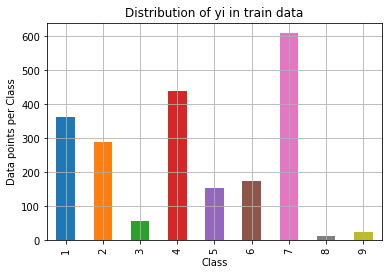

Number of data points in class 7 : 609 ( 28.672 %)
Number of data points in class 4 : 439 ( 20.669 %)
Number of data points in class 1 : 363 ( 17.09 %)
Number of data points in class 2 : 289 ( 13.606 %)
Number of data points in class 6 : 176 ( 8.286 %)
Number of data points in class 5 : 155 ( 7.298 %)
Number of data points in class 3 : 57 ( 2.684 %)
Number of data points in class 9 : 24 ( 1.13 %)
Number of data points in class 8 : 12 ( 0.565 %)


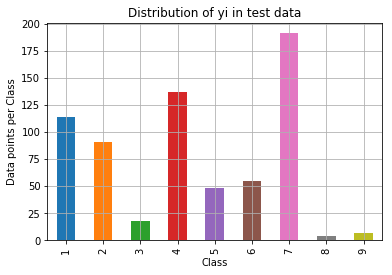

Number of data points in class 7 : 191 ( 28.722 %)
Number of data points in class 4 : 137 ( 20.602 %)
Number of data points in class 1 : 114 ( 17.143 %)
Number of data points in class 2 : 91 ( 13.684 %)
Number of data points in class 6 : 55 ( 8.271 %)
Number of data points in class 5 : 48 ( 7.218 %)
Number of data points in class 3 : 18 ( 2.707 %)
Number of data points in class 9 : 7 ( 1.053 %)
Number of data points in class 8 : 4 ( 0.602 %)


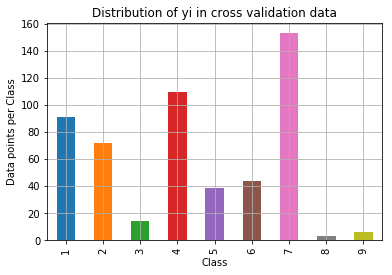

Number of data points in class 7 : 153 ( 28.759 %)
Number of data points in class 4 : 110 ( 20.677 %)
Number of data points in class 1 : 91 ( 17.105 %)
Number of data points in class 2 : 72 ( 13.534 %)
Number of data points in class 6 : 44 ( 8.271 %)
Number of data points in class 5 : 39 ( 7.331 %)
Number of data points in class 3 : 14 ( 2.632 %)
Number of data points in class 9 : 6 ( 1.128 %)
Number of data points in class 8 : 3 ( 0.564 %)


In [12]:

train_distribution = X_train['Class'].value_counts().sortlevel()
test_distribution = X_test['Class'].value_counts().sortlevel()
cv_distribution = X_cv['Class'].value_counts().sortlevel()
# distribution of class labels in train data
my_colors = 'rgbkymc'
train_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in train data')
plt.grid()
plt.show()

sorted_yi = np.argsort(-train_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',train_distribution.values[i], '(', np.round((train_distribution.values[i]/X_train.shape[0]*100), 3), '%)')

    
# distribution of class labels in test data
my_colors = 'rgbkymc'
test_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in test data')
plt.grid()
plt.show()

sorted_yi = np.argsort(-test_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',test_distribution.values[i], '(', np.round((test_distribution.values[i]/X_test.shape[0]*100), 3), '%)')

# distribution of class labels in cv data
my_colors = 'rgbkymc'
cv_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in cross validation data')
plt.grid()
plt.show()

sorted_yi = np.argsort(-train_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',cv_distribution.values[i], '(', np.round((cv_distribution.values[i]/X_cv.shape[0]*100), 3), '%)')


<h3>Building a Random Model</h3>

<p style="font-size:16px"> In a 'Random' Model, we generate the NINE class probabilites randomly such that they sum to 1. </p>

In [13]:
#confusion matrix
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0))
    
    labels = [1,2,3,4,5,6,7,8,9]
    
    print( "Confusion matrix")
    plt.figure(figsize=(20,7))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print( "Precision matrix")
    plt.figure(figsize=(20,7))
    sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    

    print( "Recall matrix")
    plt.figure(figsize=(20,7))
    sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

Log loss on Cross Validation Data using Random Model 2.4468742675179818
Log loss on Test Data using Random Model 2.460452729107529
Confusion matrix


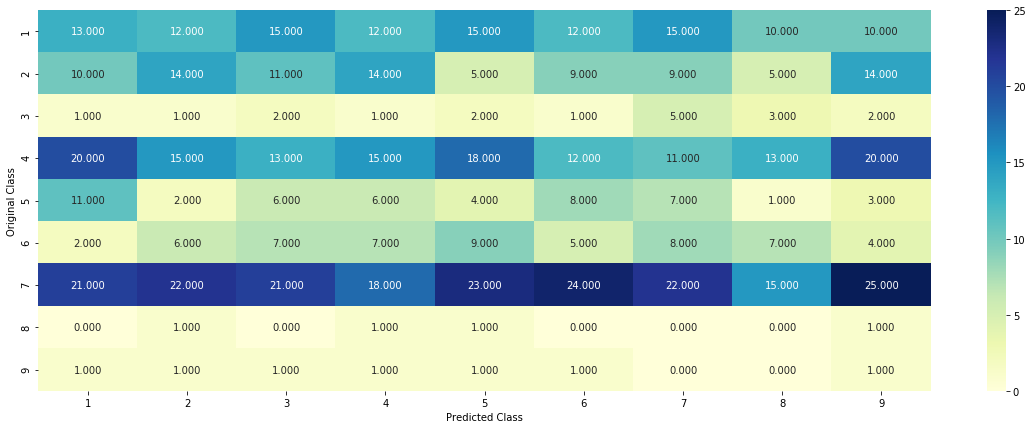

Precision matrix


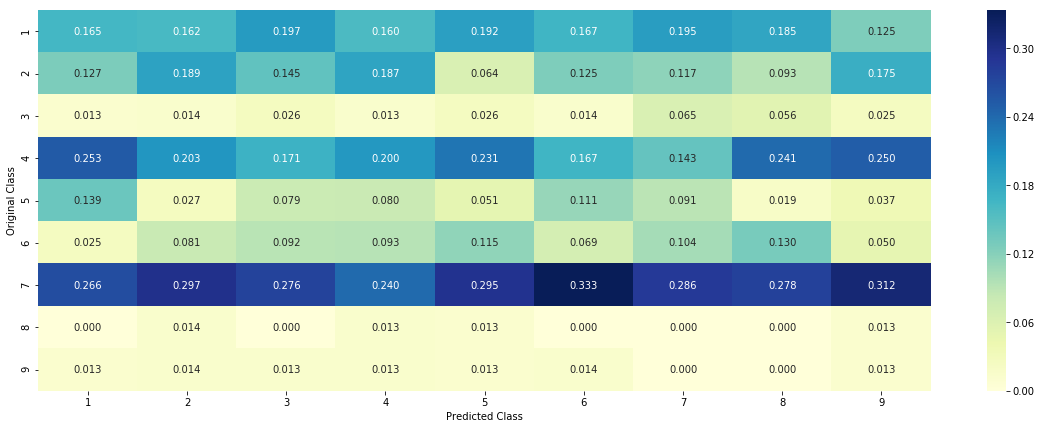

Recall matrix


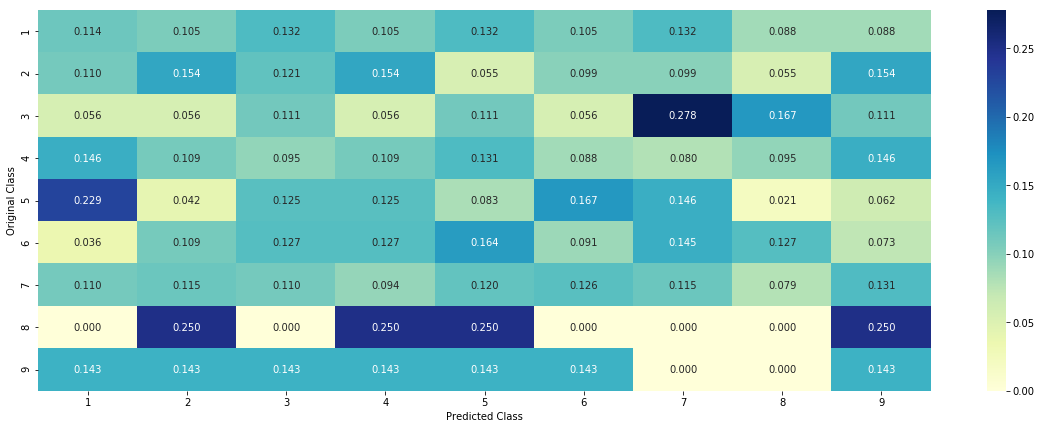

In [14]:

test_len = X_test.shape[0]
cv_len = X_cv.shape[0]


cv_predicted = np.zeros((cv_len,9))
for i in range(cv_len):
    rand_probs = np.random.rand(1,9)
    cv_predicted[i] = ((rand_probs/sum(rand_probs[0])))
print("Log loss on Cross Validation Data using Random Model",log_loss(y_cv,cv_predicted, eps=1e-15))



test_predicted = np.zeros((test_len,9))
for i in range(test_len):
    rand_probs = np.random.rand(1,9)
    test_predicted[i] = ((rand_probs/sum(rand_probs[0])))
print("Log loss on Test Data using Random Model",log_loss(y_test,test_predicted, eps=1e-15))

predicted_y =np.argmax(test_predicted, axis=1)
plot_confusion_matrix(y_test, predicted_y+1)

<h3> Univariate Analysis</h3>

<h3> Function for getting Response Coding Featurization for gene and variation</h3>

In [16]:

def get_dict(alpha, feature, df):
    
    value_count = X_train[feature].value_counts()
    
    
    dictionary = dict()
    
    
    for i, denominator in value_count.items():
        
        vec = []
        for k in range(1,10):
           
            cnt = X_train.loc[(X_train['Class']==k) & (X_train[feature]==i)]
            
           
            vec.append((cnt.shape[0] + alpha*10)/ (denominator + 90*alpha))

        
        dictionary[i]=vec
    return dictionary


def get_features(alpha, feature, df):

    dictionary = get_dict(alpha, feature, df)
    value_count = X_train[feature].value_counts()
    
   
    features = []
    
    for index, row in df.iterrows():
        if row[feature] in dict(value_count).keys():
            features.append(dictionary[row[feature]])
        else:
            features.append([1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9])

    return features

when we caculate the probability of a feature belongs to any particular class, we apply laplace smoothing
<li>(numerator + 10\*alpha) / (denominator + 90\*alpha) </li>

<h3>Univariate Analysis on Gene Feature</h3>

Gene is a categorical variable

In [17]:
unique_genes = X_train['Gene'].value_counts()
print('Number of Unique Genes :', unique_genes.shape[0])
print(unique_genes.head(10))

Number of Unique Genes : 230
BRCA1     161
TP53      108
EGFR       92
BRCA2      77
PTEN       76
BRAF       66
KIT        59
ERBB2      48
ALK        47
PIK3CA     39
Name: Gene, dtype: int64


In [18]:
print("Ans: There are", unique_genes.shape[0] ,"different categories of genes in the train data, and they are distibuted as follows",)

Ans: There are 230 different categories of genes in the train data, and they are distibuted as follows


<h3>Pdf of Gene</h3>

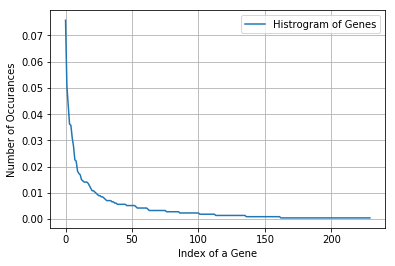

In [19]:
s = sum(unique_genes.values);
h = unique_genes.values/s;
plt.plot(h, label="Histrogram of Genes")
plt.xlabel('Index of a Gene')
plt.ylabel('Number of Occurances')
plt.legend()
plt.grid()
plt.show()


<h3> Cdf of Gene </h3>

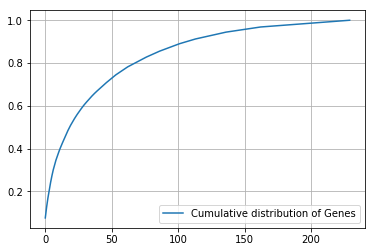

In [20]:
c = np.cumsum(h)
plt.plot(c,label='Cumulative distribution of Genes')
plt.grid()
plt.legend()
plt.show()

<h3> Featurization of Gene </h3>

We will use two types of featurization
1)One Hot Encoding

2)Response Coding

In [21]:
#response-coding of the Gene feature
# alpha is used for laplace smoothing
alpha = 1

train_gene_feature_responseCoding = np.array(get_features(alpha, "Gene", X_train))

test_gene_feature_responseCoding = np.array(get_features(alpha, "Gene",X_test))

cv_gene_feature_responseCoding = np.array(get_features(alpha, "Gene", X_cv))

In [22]:
print("train_gene_feature_responseCoding is converted feature using respone coding method. The shape of gene feature:", train_gene_feature_responseCoding.shape)

train_gene_feature_responseCoding is converted feature using respone coding method. The shape of gene feature: (2124, 9)


In [23]:
# one-hot encoding of Gene feature.
gene_vectorizer = TfidfVectorizer()
train_gene_feature_onehotCoding = gene_vectorizer.fit_transform(X_train['Gene'])
test_gene_feature_onehotCoding = gene_vectorizer.transform(X_test['Gene'])
cv_gene_feature_onehotCoding = gene_vectorizer.transform(X_cv['Gene'])

In [24]:
X_train['Gene'].head()

2596    BRCA1
2727     BRAF
2056      MYC
1426    FGFR3
961     KDM5C
Name: Gene, dtype: object

In [25]:
print("train_gene_feature_onehotCoding is converted feature using one-hot encoding method. The shape of gene feature:", train_gene_feature_onehotCoding.shape)






train_gene_feature_onehotCoding is converted feature using one-hot encoding method. The shape of gene feature: (2124, 229)


<h3> How good is gene feature in predicting cancer class label </h3>

In this case we used only gene column and checked whether this feature is useful in predicted cancer class 

For values of alpha =  1e-05 The log loss is: 1.3653382433772223
For values of alpha =  0.0001 The log loss is: 1.1743154618544391
For values of alpha =  0.001 The log loss is: 1.1999599779678212
For values of alpha =  0.01 The log loss is: 1.3441038412545452
For values of alpha =  0.1 The log loss is: 1.4529131359317906
For values of alpha =  1 The log loss is: 1.489161560329125


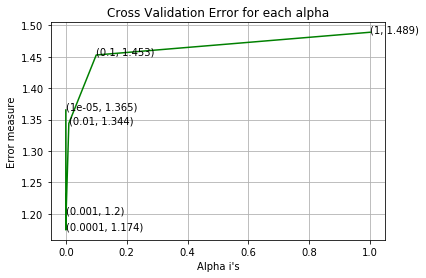

For values of best alpha =  0.0001 The train log loss is: 1.0522599244318958
For values of best alpha =  0.0001 The cross validation log loss is: 1.1743154618544391
For values of best alpha =  0.0001 The test log loss is: 1.1963109149103397


In [26]:
alpha = [10 ** x for x in range(-5, 1)] 


cv_error=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_gene_feature_onehotCoding, y_train)
    clf_cali = CalibratedClassifierCV(clf, method="sigmoid")
    clf_cali.fit(train_gene_feature_onehotCoding, y_train)
    predict_y = clf_cali.predict_proba(cv_gene_feature_onehotCoding)
    cv_error.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, cv_error,c='g')
for i, txt in enumerate(np.round(cv_error,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_error[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_error)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_gene_feature_onehotCoding, y_train)
clf_cali = CalibratedClassifierCV(clf, method="sigmoid")
clf_cali.fit(train_gene_feature_onehotCoding, y_train)

predict_y = clf_cali.predict_proba(train_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = clf_cali.predict_proba(cv_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = clf_cali.predict_proba(test_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


<h3> Is gene Feature Stable? </h3>

Yes, the gene feature is stable , because test log loss and cv log loss are very close to train log loss

In [32]:
print("Q6. How many data points in Test and CV datasets are covered by the ", unique_genes.shape[0], " genes in train dataset?")

test_common_train=X_test[X_test['Gene'].isin(list(set(X_train['Gene'])))].shape[0]
cv_common_train=X_cv[X_cv['Gene'].isin(list(set(X_train['Gene'])))].shape[0]

print('Ans\n1. In test data',test_common_train, 'out of',X_test.shape[0], ":",(test_common_train/X_test.shape[0])*100)
print('2. In cross validation data',cv_common_train, 'out of ',X_cv.shape[0],":" ,(cv_common_train/X_cv.shape[0])*100)




Q6. How many data points in Test and CV datasets are covered by the  230  genes in train dataset?
Ans
1. In test data 645 out of 665 : 96.99248120300751
2. In cross validation data 508 out of  532 : 95.48872180451127


This analysis also states that Gene feature is stable

<h3>Univariate Analysis on Variation Feature</h3>

Variation is a categorical variable

In [33]:
unique_variations = X_train['Variation'].value_counts()
print('Number of Unique Variations :', unique_variations.shape[0])
print(unique_variations.head(10))

Number of Unique Variations : 1938
Truncating_Mutations    57
Deletion                44
Amplification           43
Fusions                 19
Overexpression           4
G12V                     4
E17K                     3
Q209L                    2
T286A                    2
A146T                    2
Name: Variation, dtype: int64


In [34]:
print("Ans: There are", unique_variations.shape[0] ,"different categories of variations in the train data, and they are distibuted as follows",)




Ans: There are 1938 different categories of variations in the train data, and they are distibuted as follows


<h3> Pdf of Variation </h3>

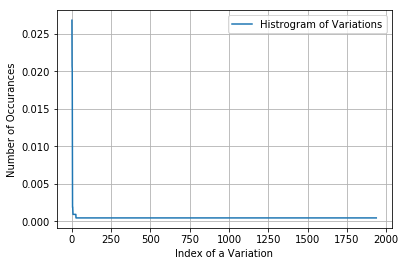

In [35]:
s = sum(unique_variations.values);
h = unique_variations.values/s;
plt.plot(h, label="Histrogram of Variations")
plt.xlabel('Index of a Variation')
plt.ylabel('Number of Occurances')
plt.legend()
plt.grid()
plt.show()

<h3>Cdf of Variation </h3>

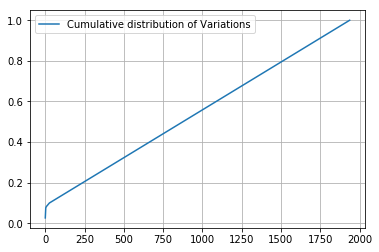

In [31]:
c = np.cumsum(h)
#print(c)
plt.plot(c,label='Cumulative distribution of Variations')
plt.grid()
plt.legend()
plt.show()

<h3> Featurization of Variation </h3>

We will use two techniques
1)One-Hot-Encoding

2)Response Coding

In [36]:
#  response coding and here alpha is used for laplace smoothing
alpha = 1

train_variation_feature_responseCoding = np.array(get_features(alpha, "Variation", X_train))

test_variation_feature_responseCoding = np.array(get_features(alpha, "Variation", X_test))
cv_variation_feature_responseCoding = np.array(get_features(alpha, "Variation", X_cv))

In [37]:
print("train_variation_feature_responseCoding is a converted feature using the response coding method. The shape of Variation feature:", train_variation_feature_responseCoding.shape)



train_variation_feature_responseCoding is a converted feature using the response coding method. The shape of Variation feature: (2124, 9)


In [38]:
# one-hot encoding of variation feature.
variation_vectorizer = TfidfVectorizer()
train_variation_feature_onehotCoding = variation_vectorizer.fit_transform(X_train['Variation'])
test_variation_feature_onehotCoding = variation_vectorizer.transform(X_test['Variation'])
cv_variation_feature_onehotCoding = variation_vectorizer.transform(X_cv['Variation'])

In [39]:
print("train_variation_feature_onehotEncoded is converted feature using the onne-hot encoding method. The shape of Variation feature:", train_variation_feature_onehotCoding.shape)

train_variation_feature_onehotEncoded is converted feature using the onne-hot encoding method. The shape of Variation feature: (2124, 1964)


# <p style="font-size:18px;"> <b></b> How good is this Variation feature  in  predicted cancer class?</p>

We build a model just like we did for gene

For values of alpha =  1e-05 The log loss is: 1.6969997289351946
For values of alpha =  0.0001 The log loss is: 1.6933132001535482
For values of alpha =  0.001 The log loss is: 1.694257491423
For values of alpha =  0.01 The log loss is: 1.7048804120880936
For values of alpha =  0.1 The log loss is: 1.7152876950436202
For values of alpha =  1 The log loss is: 1.7182009219005876


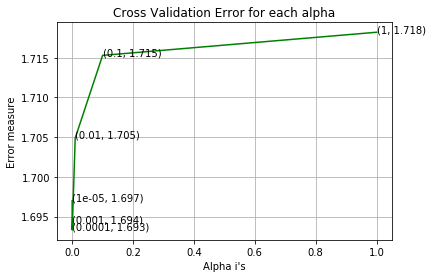

For values of best alpha =  0.0001 The train log loss is: 0.7687696879461972
For values of best alpha =  0.0001 The cross validation log loss is: 1.6933132001535482
For values of best alpha =  0.0001 The test log loss is: 1.7023163669215249


In [41]:
alpha = [10 ** x for x in range(-5, 1)]

cv_error=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_variation_feature_onehotCoding, y_train)
    
    clf_cali = CalibratedClassifierCV(clf, method="sigmoid")
    clf_cali.fit(train_variation_feature_onehotCoding, y_train)
    predict_y = clf_cali.predict_proba(cv_variation_feature_onehotCoding)
    
    cv_error.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, cv_error,c='g')
for i, txt in enumerate(np.round(cv_error,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_error[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_error)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_variation_feature_onehotCoding, y_train)
clf_cali = CalibratedClassifierCV(clf, method="sigmoid")
clf_cali.fit(train_variation_feature_onehotCoding, y_train)

predict_y = clf_cali.predict_proba(train_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = clf_cali.predict_proba(cv_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = clf_cali.predict_proba(test_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


<h3>Is the Variation feature stable across all the data sets</h3>
By looking at the log loss values, we are not sure , so we did below analysis

In [42]:
print("Q12. How many data points are covered by total ", unique_variations.shape[0], " genes in test and cross validation data sets?")
test_common_train=X_test[X_test['Variation'].isin(list(set(X_train['Variation'])))].shape[0]
cv_common_train=X_cv[X_cv['Variation'].isin(list(set(X_train['Variation'])))].shape[0]
print('Ans\n1. In test data',test_common_train, 'out of',X_test.shape[0], ":",(test_common_train/X_test.shape[0])*100)
print('2. In cross validation data',cv_common_train, 'out of ',X_cv.shape[0],":" ,(cv_common_train/X_cv.shape[0])*100)



Q12. How many data points are covered by total  1938  genes in test and cross validation data sets?
Ans
1. In test data 76 out of 665 : 11.428571428571429
2. In cross validation data 57 out of  532 : 10.714285714285714


So here we can see that there is not much overlap between train and cv as well as between train and test, hence this feature is not stable,but we will keep this feature as its log loss on test and cv is significantly less than random models log loss

<h3> Univariate Analysis on Text Feature</h3>

In [47]:
def extract_dictionary(text):
    dictionary = defaultdict(int)
    for index, row in text.iterrows():
        for word in row['TEXT'].split():
            dictionary[word] +=1
    return dictionary

In [48]:
import math
def responsecoding(df):
    text_feature_responseCoding = np.zeros((df.shape[0],9))
    for i in range(0,9):
        row_index = 0
        for index, row in df.iterrows():
            sum_prob = 0
            for word in row['TEXT'].split():
                sum_prob += math.log(((dict_list[i].get(word,0)+10 )/(class_list[i]+90)))
            text_feature_responseCoding[row_index][i] = math.exp(sum_prob/len(row['TEXT'].split()))
            row_index += 1
    return text_feature_responseCoding

In [49]:
#tfidf vectorizer for text
text_vectorizer = TfidfVectorizer(max_features=1000,ngram_range=(1, 4))
train_text_feature_onehotCoding = text_vectorizer.fit_transform(X_train['TEXT'])

train_text_features= text_vectorizer.get_feature_names()
train_text_fea_counts = train_text_feature_onehotCoding.sum(axis=0).A1
text_dict = dict(zip(list(train_text_features),train_text_fea_counts))
                 


In [50]:
print("total no of unique words in train data",len(train_text_features))

total no of unique words in train data 1000


In [51]:
dict_list=[]
for i in range(1,10):
    text= X_train[X_train['Class']==i]
    dict_list.append(extract_dictionary(text))
    
    
class_list=[]
for i in range(1,10):
    class_list.append(X_train[X_train['Class']==i].shape[0])

In [52]:
#response coding of text features
train_text_feature_responseCoding  = responsecoding(X_train)
test_text_feature_responseCoding  = responsecoding(X_test)
cv_text_feature_responseCoding  = responsecoding(X_cv)

In [53]:
train_text_feature_responseCoding = (train_text_feature_responseCoding.T/train_text_feature_responseCoding.sum(axis=1)).T
test_text_feature_responseCoding = (test_text_feature_responseCoding.T/test_text_feature_responseCoding.sum(axis=1)).T
cv_text_feature_responseCoding = (cv_text_feature_responseCoding.T/cv_text_feature_responseCoding.sum(axis=1)).T

In [54]:
train_text_feature_onehotCoding = normalize(train_text_feature_onehotCoding, axis=0)


test_text_feature_onehotCoding = text_vectorizer.transform(X_test['TEXT'])

test_text_feature_onehotCoding = normalize(test_text_feature_onehotCoding, axis=0)


cv_text_feature_onehotCoding = text_vectorizer.transform(X_cv['TEXT'])

cv_text_feature_onehotCoding = normalize(cv_text_feature_onehotCoding, axis=0)

<h3> How good is text feature in predicting cancer class label?</h3>

For values of alpha =  1e-05 The log loss is: 1.084837024814774
For values of alpha =  0.0001 The log loss is: 1.1354806278560066
For values of alpha =  0.001 The log loss is: 1.4407110065363835
For values of alpha =  0.01 The log loss is: 1.9060241959920319
For values of alpha =  0.1 The log loss is: 2.0323750160627565
For values of alpha =  1 The log loss is: 2.0175632062790165


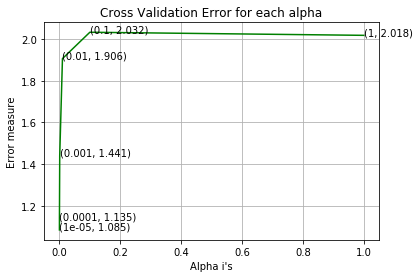

For values of best alpha =  1e-05 The train log loss is: 0.7987478925882097
For values of best alpha =  1e-05 The cross validation log loss is: 1.084837024814774
For values of best alpha =  1e-05 The test log loss is: 1.110309602451061


In [55]:

alpha = [10 ** x for x in range(-5, 1)]

cv_error=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_text_feature_onehotCoding, y_train)
    
    clf_cali = CalibratedClassifierCV(clf, method="sigmoid")
    clf_cali.fit(train_text_feature_onehotCoding, y_train)
    predict_y = clf_cali.predict_proba(cv_text_feature_onehotCoding)
    cv_error.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, cv_error,c='g')
for i, txt in enumerate(np.round(cv_error,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_error[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_error)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_text_feature_onehotCoding, y_train)
clf_cali = CalibratedClassifierCV(clf, method="sigmoid")
clf_cali.fit(train_text_feature_onehotCoding, y_train)

predict_y = clf_cali.predict_proba(train_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = clf_cali.predict_proba(cv_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = clf_cali.predict_proba(test_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


<h3>Is the Text feature stable across all the data sets?</h3>
Yes, it  looks like, but to confirm that we found the overlap between train,test ansd cv 

In [56]:
def get_common(df):
    text_vec = TfidfVectorizer(max_features=1000,ngram_range=(1, 4))
    text_fea = text_vec.fit_transform(df['TEXT'])
    text_features = text_vec.get_feature_names()

    text_fea_counts = text_fea.sum(axis=0).A1
    text_fea_dict = dict(zip(list(text_features),text_fea_counts))
    len1 = len(set(text_features))
    len2 = len(set(train_text_features) & set(text_features))
    return len1,len2

In [57]:
len1,len2 = get_common(X_test)
print(np.round((len2/len1)*100, 3), "% of word of test data appeared in train data")
len1,len2 = get_common(X_cv)
print(np.round((len2/len1)*100, 3), "% of word of Cross Validation appeared in train data")

94.1 % of word of test data appeared in train data
93.9 % of word of Cross Validation appeared in train data


So the text feature is stable

<h3>Function for getting imp features</h3>

In [58]:
def impfeature_names(indices, text, gene, var, no_features):
    gene_count_vec = TfidfVectorizer()
    var_count_vec = TfidfVectorizer()
    text_count_vec = TfidfVectorizer(max_features=1000,ngram_range=(1, 4))
    
    gene_vec = gene_count_vec.fit(X_train['Gene'])
    var_vec  = var_count_vec.fit(X_train['Variation'])
    text_vec = text_count_vec.fit(X_train['TEXT'])
    
    fea1_len = len(gene_vec.get_feature_names())
    fea2_len = len(var_count_vec.get_feature_names())
    
    word_present = 0
    for i,v in enumerate(indices):
        if (v < fea1_len):
            word = gene_vec.get_feature_names()[v]
            yes_no = True if word == gene else False
            if yes_no:
                word_present += 1
                print(i, "Gene feature [{}] present in test data point [{}]".format(word,yes_no))
        elif (v < fea1_len+fea2_len):
            word = var_vec.get_feature_names()[v-(fea1_len)]
            yes_no = True if word == var else False
            if yes_no:
                word_present += 1
                print(i, "variation feature [{}] present in test data point [{}]".format(word,yes_no))
        else:
            word = text_vec.get_feature_names()[v-(fea1_len+fea2_len)]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
                print(i, "Text feature [{}] present in test data point [{}]".format(word,yes_no))

    print("Out of the top ",no_features," features ", word_present, "are present in query point")

<h3> Stacking 3 types Of Features </h3>

In [59]:
# merging gene, variance and text features for train ,cv and test



train_gene_var_onehotCoding = hstack((train_gene_feature_onehotCoding,train_variation_feature_onehotCoding))
test_gene_var_onehotCoding = hstack((test_gene_feature_onehotCoding,test_variation_feature_onehotCoding))
cv_gene_var_onehotCoding = hstack((cv_gene_feature_onehotCoding,cv_variation_feature_onehotCoding))

train_onehotCoding = hstack((train_gene_var_onehotCoding, train_text_feature_onehotCoding)).tocsr()
train_y = np.array(list(X_train['Class']))

test_onehotCoding = hstack((test_gene_var_onehotCoding, test_text_feature_onehotCoding)).tocsr()
test_y = np.array(list(X_test['Class']))

cv_onehotCoding = hstack((cv_gene_var_onehotCoding, cv_text_feature_onehotCoding)).tocsr()
cv_y = np.array(list(X_cv['Class']))


train_gene_var_responseCoding = np.hstack((train_gene_feature_responseCoding,train_variation_feature_responseCoding))
test_gene_var_responseCoding = np.hstack((test_gene_feature_responseCoding,test_variation_feature_responseCoding))
cv_gene_var_responseCoding = np.hstack((cv_gene_feature_responseCoding,cv_variation_feature_responseCoding))

train_responseCoding = np.hstack((train_gene_var_responseCoding, train_text_feature_responseCoding))
test_responseCoding = np.hstack((test_gene_var_responseCoding, test_text_feature_responseCoding))
cv_responseCoding = np.hstack((cv_gene_var_responseCoding, cv_text_feature_responseCoding))


In [60]:
print("One hot encoding features :")
print("number of data points * number of features in train data = ", train_onehotCoding.shape)
print("(number of data points * number of features in test data = ", test_onehotCoding.shape)
print("(number of data points * number of features in cross validation data =", cv_onehotCoding.shape)

One hot encoding features :
number of data points * number of features in train data =  (2124, 3193)
(number of data points * number of features in test data =  (665, 3193)
(number of data points * number of features in cross validation data = (532, 3193)


In [61]:
print(" Response encoding features :")
print("(number of data points * number of features) in train data = ", train_responseCoding.shape)
print("(number of data points * number of features) in test data = ", test_responseCoding.shape)
print("(number of data points * number of features) in cross validation data =", cv_responseCoding.shape)

 Response encoding features :
(number of data points * number of features) in train data =  (2124, 27)
(number of data points * number of features) in test data =  (665, 27)
(number of data points * number of features) in cross validation data = (532, 27)


<h1> Machine Learning Models </h1>

<h3> Base Line Model</h3>

<h3> Naive Bayes</h3>

<h3> Hyper parameter tuning</h3>

For values of alpha =  1e-05 The log loss is: 1.175465816690511
For values of alpha =  0.0001 The log loss is: 1.1761003677308441
For values of alpha =  0.001 The log loss is: 1.1752331143576629
For values of alpha =  0.01 The log loss is: 1.1669515106716966
For values of alpha =  0.1 The log loss is: 1.1873907438321065
For values of alpha =  1 The log loss is: 1.230859851952897
For values of alpha =  10 The log loss is: 1.4372243420350947
For values of alpha =  100 The log loss is: 1.4416870600848195
For values of alpha =  1000 The log loss is: 1.4359647472723045


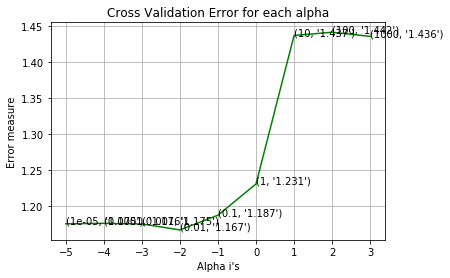

For values of best alpha =  0.01 The train log loss is: 0.5439382311721307
For values of best alpha =  0.01 The cross validation log loss is: 1.1669515106716966
For values of best alpha =  0.01 The test log loss is: 1.1664169256894446


In [62]:
alpha = [0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000]

cv_error=[]
for i in alpha:
    clf = MultinomialNB(alpha=i)
    clf.fit(train_onehotCoding,train_y)
    
    clf_cali = CalibratedClassifierCV(clf, method="sigmoid")
    clf_cali.fit(train_onehotCoding,train_y)
    predict_y = clf_cali.predict_proba(cv_onehotCoding)
    cv_error.append(log_loss(cv_y, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    
fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_error,c='g')
for i, txt in enumerate(np.round(cv_error,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_error[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()



best_alpha = np.argmin(cv_error)
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_onehotCoding,train_y)
clf_cali = CalibratedClassifierCV(clf, method="sigmoid")
clf_cali.fit(train_onehotCoding, train_y)

predict_y = clf_cali.predict_proba(train_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(train_y, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = clf_cali.predict_proba(cv_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(cv_y, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = clf_cali.predict_proba(test_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(test_y, predict_y, labels=clf.classes_, eps=1e-15))


<h3> Testing the model with best hyper paramters</h3>

Log Loss : 1.1669515106716966
Number of missclassified point : 0.3609022556390977
Confusion matrix


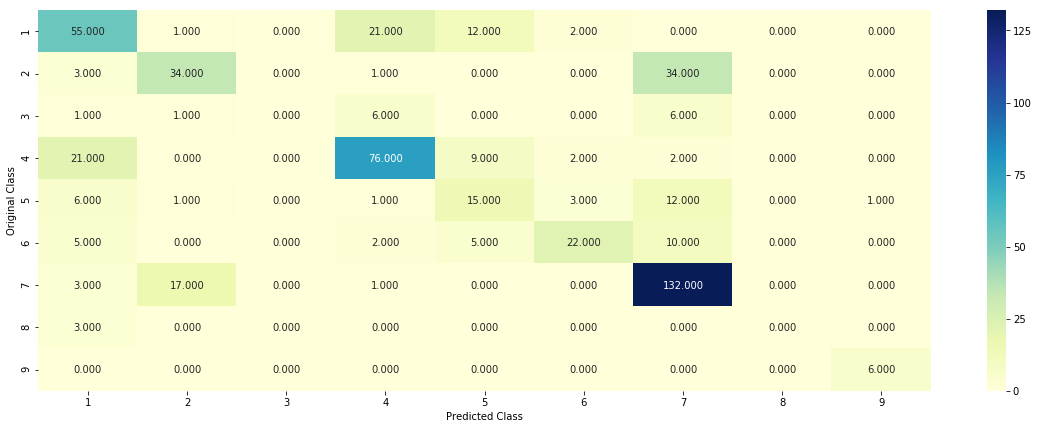

Precision matrix


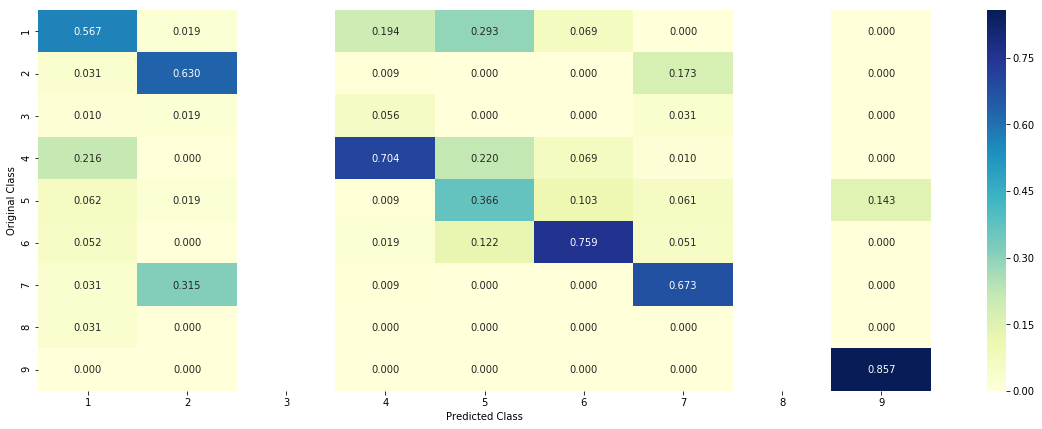

Recall matrix


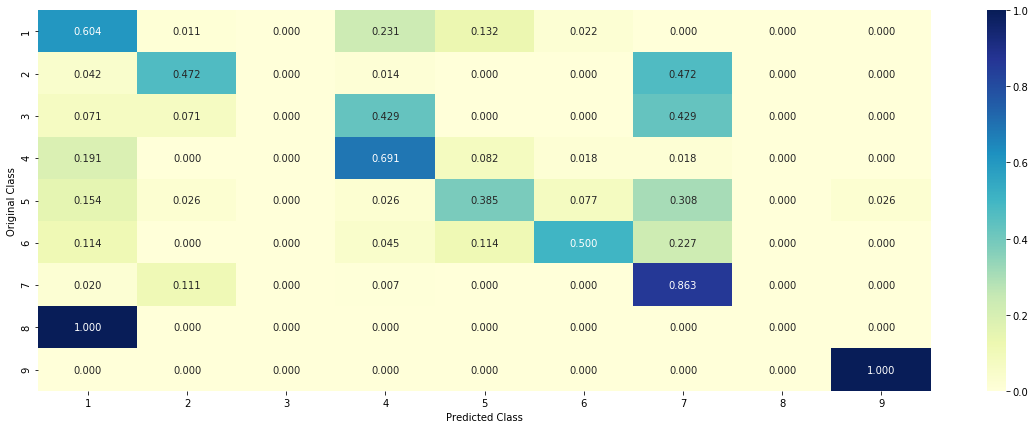

In [63]:
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_onehotCoding, train_y)
clf_cali = CalibratedClassifierCV(clf, method="sigmoid")
clf_cali.fit(train_onehotCoding, train_y)
clf_probs = clf_cali.predict_proba(cv_onehotCoding)
print("Log Loss :",log_loss(cv_y, clf_probs))
print("Number of missclassified point :", np.count_nonzero((clf_cali.predict(cv_onehotCoding)- cv_y))/cv_y.shape[0])
plot_confusion_matrix(cv_y, clf_cali.predict(cv_onehotCoding))

<h3>Calculating important Features for a query point</h3>

In [64]:
test_query_point=100
num_feature = 100
predicted_class = clf_cali.predict(test_onehotCoding[test_query_point])
print("Predicted Class :", predicted_class[0])
print("Predicted Class Probabilities:", np.round(clf_cali.predict_proba(test_onehotCoding[test_query_point]),3))
print("Actual Class :", y_test[test_query_point])
indices = np.argsort(-clf.coef_)[predicted_class-1][:,:num_feature]
impfeature_names(indices[0], X_test['TEXT'].iloc[test_query_point],X_test['Gene'].iloc[test_query_point],X_test['Variation'].iloc[test_query_point], num_feature)



Predicted Class : 6
Predicted Class Probabilities: [[0.059 0.043 0.01  0.073 0.035 0.687 0.085 0.004 0.003]]
Actual Class : 6
5 Text feature [brca] present in test data point [True]
8 Text feature [deleterious] present in test data point [True]
10 Text feature [classified] present in test data point [True]
12 Text feature [basis] present in test data point [True]
13 Text feature [history] present in test data point [True]
15 Text feature [brca1] present in test data point [True]
16 Text feature [predicted] present in test data point [True]
17 Text feature [49] present in test data point [True]
20 Text feature [expected] present in test data point [True]
21 Text feature [family] present in test data point [True]
22 Text feature [26] present in test data point [True]
23 Text feature [models] present in test data point [True]
25 Text feature [000] present in test data point [True]
26 Text feature [model] present in test data point [True]
27 Text feature [sequence] present in test data poi

<h3>K Nearest Neighbour </h3>

<h3> Hyper parameter tuning</h3>

for alpha= 3
Log Loss : 0.9885474868747954
for alpha= 5
Log Loss : 0.9528367640206713
for alpha= 11
Log Loss : 0.9751916542235314
for alpha= 15
Log Loss : 0.9954970558724908
for alpha= 21
Log Loss : 1.005435613957252
for alpha= 31
Log Loss : 1.0123509088351597
for alpha= 41
Log Loss : 1.014889884815298
for alpha= 51
Log Loss : 1.0173230360040308
for alpha= 99
Log Loss : 1.0356442735201785


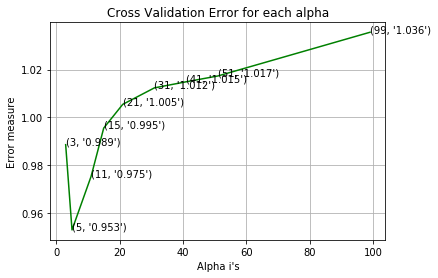

For values of best alpha =  5 The train log loss is: 0.5065500344388233
For values of best alpha =  5 The cross validation log loss is: 0.9528367640206713
For values of best alpha =  5 The test log loss is: 1.0479796802966999


In [65]:
alpha=[3,5,11,15,21,31,41,51,99]
cv_error=[]
for i in alpha:
    print("for alpha=",i)
    clf = KNeighborsClassifier(n_neighbors=i)
    clf.fit(train_responseCoding,train_y)
    clf_cali= CalibratedClassifierCV(clf,method="sigmoid")
    clf_cali.fit(train_responseCoding,train_y)
    clf_probs=clf_cali.predict_proba(cv_responseCoding)
    cv_error.append(log_loss(cv_y,clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, clf_probs)) 
    

fig, ax = plt.subplots()
ax.plot(alpha, cv_error,c='g')
for i, txt in enumerate(np.round(cv_error,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_error[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

                
                
best_alpha=np.argmin(cv_error)
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_responseCoding,train_y)
clf_cali= CalibratedClassifierCV(clf,method="sigmoid")
clf_cali.fit(train_responseCoding,train_y)
                

                
                
predict_y = clf_cali.predict_proba(train_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(train_y, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = clf_cali.predict_proba(cv_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(cv_y, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = clf_cali.predict_proba(test_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(test_y, predict_y, labels=clf.classes_, eps=1e-15))


<h3> Testing the model with best hyper paramters</h3>

Log Loss : 0.9528367640206713
Number of missclassified point : 0.31203007518796994
Confusion matrix


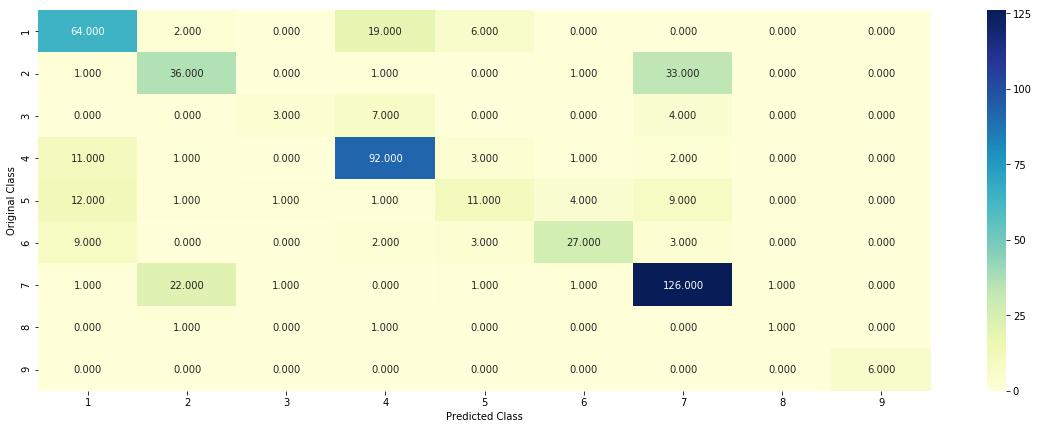

Precision matrix


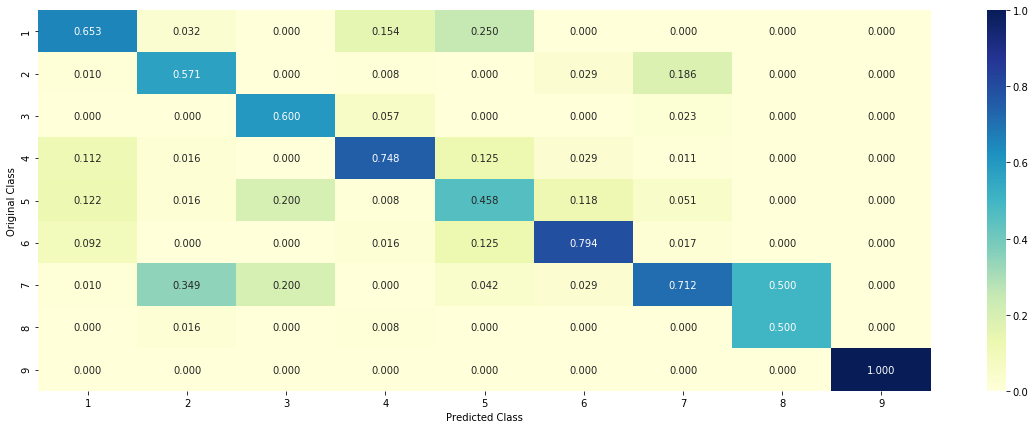

Recall matrix


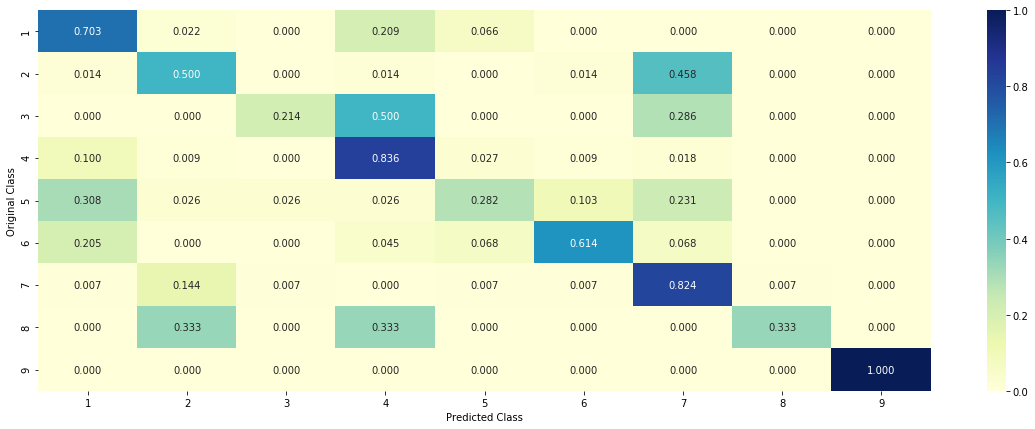

In [66]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_responseCoding, train_y)
clf_cali = CalibratedClassifierCV(clf, method="sigmoid")
clf_cali.fit(train_responseCoding, train_y)
clf_probs = clf_cali.predict_proba(cv_responseCoding)
print("Log Loss :",log_loss(cv_y, clf_probs))
print("Number of missclassified point :", np.count_nonzero((clf_cali.predict(cv_responseCoding)- cv_y))/cv_y.shape[0])
plot_confusion_matrix(cv_y, clf_cali.predict(cv_responseCoding))

<h3>Calculating Nearest Neighbours for a Query Point</h3>

In [67]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_responseCoding, train_y)
clf_cali = CalibratedClassifierCV(clf, method="sigmoid")
clf_cali.fit(train_responseCoding, train_y)
test_query_point=6
predicted_class = clf_cali.predict(test_responseCoding[test_query_point].reshape(1,-1))
print("predicted class:",predicted_class[0])
print("Actual Class :", test_y[test_query_point])
neighbors=clf.kneighbors(test_responseCoding[test_query_point].reshape(1, -1), alpha[best_alpha])
print("the",alpha[best_alpha], "nearest neighbors are", train_y[neighbors[1][0]]) 

predicted class: 4
Actual Class : 3
the 5 nearest neighbors are [4 4 4 4 4]


<h3> Logistic Regression</h3>

<h3>With Class balancing</h3>

<h3> Hyper paramter tuning</h3>

for alpha = 1e-06
Log Loss : 1.119993823555522
for alpha = 1e-05
Log Loss : 1.0563275158599272
for alpha = 0.0001
Log Loss : 0.9599429889299582
for alpha = 0.001
Log Loss : 1.0000183138717977
for alpha = 0.01
Log Loss : 1.1898137743262067
for alpha = 0.1
Log Loss : 1.624626904852891
for alpha = 1
Log Loss : 1.7706889372081942
for alpha = 10
Log Loss : 1.7873613576169969
for alpha = 100
Log Loss : 1.7891918410042877


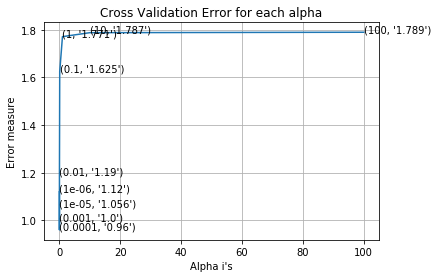

For values of best alpha =  0.0001 The train log loss is: 0.4647054137045836
For values of best alpha =  0.0001 The cross validation log loss is: 0.9599429889299582
For values of best alpha =  0.0001 The test log loss is: 0.9664330712564366


In [68]:

alpha = [10 ** x for x in range(-6, 3)]
cv_error = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_onehotCoding, train_y)
    clf_cali = CalibratedClassifierCV(clf, method="sigmoid")
    clf_cali.fit(train_onehotCoding, train_y)
    clf_probs = clf_cali.predict_proba(cv_onehotCoding)
    cv_error.append(log_loss(cv_y, clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_error)
for i, txt in enumerate(np.round(cv_error,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_error[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_error)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_onehotCoding, train_y)
clf_cali = CalibratedClassifierCV(clf, method="sigmoid")
clf_cali.fit(train_onehotCoding, train_y)

predict_y = clf_cali.predict_proba(train_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = clf_cali.predict_proba(cv_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = clf_cali.predict_proba(test_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))





<h3> Testing the model with best hyper paramters</h3>

Log Loss : 0.9599429889299582
Number of missclassified point : 0.31390977443609025
Confusion matrix


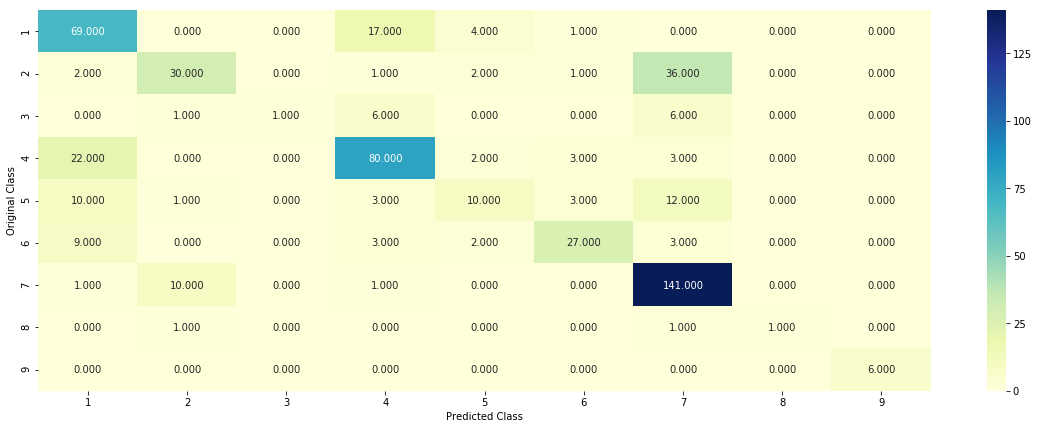

Precision matrix


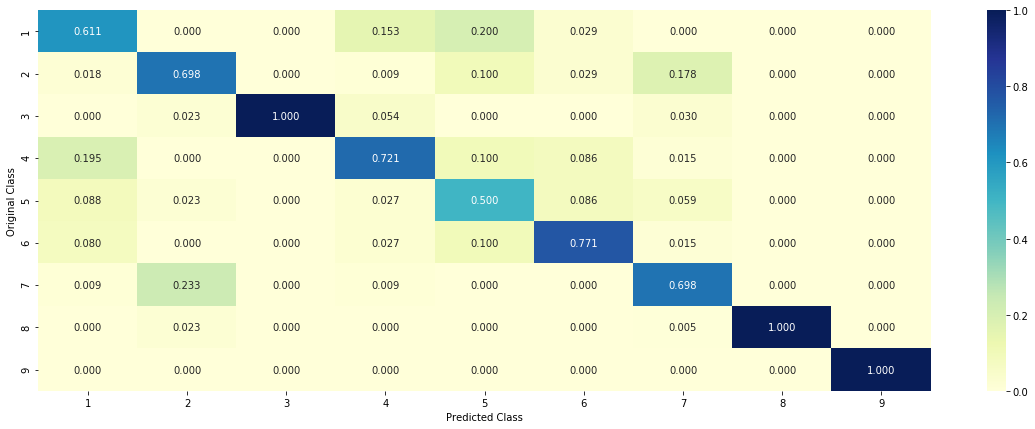

Recall matrix


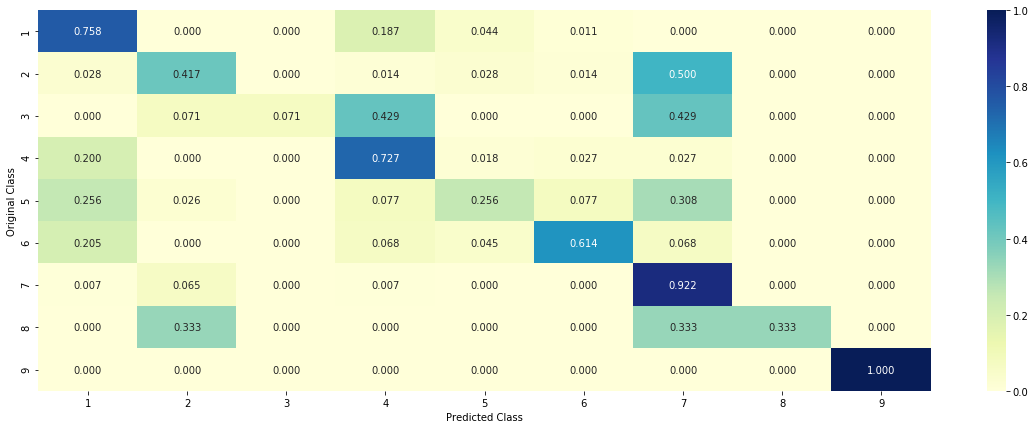

In [69]:
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_onehotCoding, train_y)
clf_cali = CalibratedClassifierCV(clf, method="sigmoid")
clf_cali.fit(train_onehotCoding, train_y)
clf_probs = clf_cali.predict_proba(cv_onehotCoding)
print("Log Loss :",log_loss(cv_y, clf_probs))
print("Number of missclassified point :", np.count_nonzero((clf_cali.predict(cv_onehotCoding)- cv_y))/cv_y.shape[0])
plot_confusion_matrix(cv_y, clf_cali.predict(cv_onehotCoding))

<h3>Important Features for a Query Point</h5>

In [70]:

test_query_point = 1
num_feature = 500
predicted_cls = clf_cali.predict(test_onehotCoding[test_query_point])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(clf_cali.predict_proba(test_onehotCoding[test_query_point]),3))
print("Actual Class :", test_y[test_query_point])
indices = np.argsort(-abs(clf.coef_))[predicted_cls-1][:,:num_feature]

impfeature_names(indices[0], X_test['TEXT'].iloc[test_query_point],X_test['Gene'].iloc[test_query_point],X_test['Variation'].iloc[test_query_point], num_feature)


Predicted Class : 7
Predicted Class Probabilities: [[0.035 0.133 0.022 0.056 0.023 0.023 0.689 0.008 0.011]]
Actual Class : 7
36 Text feature [downstream] present in test data point [True]
89 Text feature [expressing] present in test data point [True]
90 Text feature [pathways] present in test data point [True]
100 Text feature [enhanced] present in test data point [True]
106 Text feature [overexpression] present in test data point [True]
117 Text feature [activated] present in test data point [True]
131 Text feature [oncogene] present in test data point [True]
158 Text feature [activation] present in test data point [True]
192 Text feature [conserved] present in test data point [True]
197 Text feature [approximately] present in test data point [True]
206 Text feature [3b] present in test data point [True]
223 Text feature [missense] present in test data point [True]
238 Text feature [substrate] present in test data point [True]
239 Text feature [affected] present in test data point [T

<h3>Logistic Regression Without Class balancing</h3>

<h3> Hyper paramter tuning</h3>

for alpha = 1e-06
Log Loss : 1.1242935619460643
for alpha = 1e-05
Log Loss : 1.103659450371651
for alpha = 0.0001
Log Loss : 0.9967587557089528
for alpha = 0.001
Log Loss : 1.0696455236874258
for alpha = 0.01
Log Loss : 1.319226762677143
for alpha = 0.1
Log Loss : 1.6931179285091678
for alpha = 1
Log Loss : 1.7943593288297146


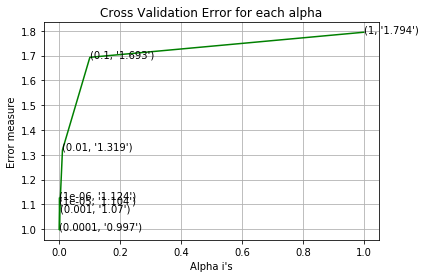

For values of best alpha =  0.0001 The train log loss is: 0.45676686783556725
For values of best alpha =  0.0001 The cross validation log loss is: 0.9967587557089528
For values of best alpha =  0.0001 The test log loss is: 0.9965483963352267


In [71]:

alpha = [10 ** x for x in range(-6, 1)]
cv_error = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_onehotCoding, train_y)
    clf_cali = CalibratedClassifierCV(clf, method="sigmoid")
    clf_cali.fit(train_onehotCoding, train_y)
    clf_probs = clf_cali.predict_proba(cv_onehotCoding)
    cv_error.append(log_loss(cv_y, clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_error,c='g')
for i, txt in enumerate(np.round(cv_error,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_error[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_error)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_onehotCoding, train_y)
clf_cali = CalibratedClassifierCV(clf, method="sigmoid")
clf_cali.fit(train_onehotCoding, train_y)

predict_y = clf_cali.predict_proba(train_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = clf_cali.predict_proba(cv_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = clf_cali.predict_proba(test_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

<h3> Testing model with best hyper parameters</h3>

Log Loss : 0.9967587557089528
Number of missclassified point : 0.3157894736842105
Confusion matrix


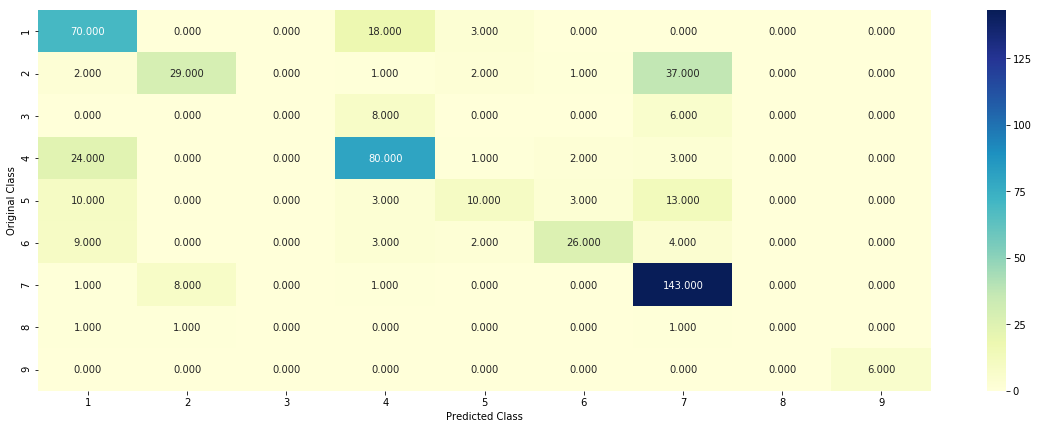

Precision matrix


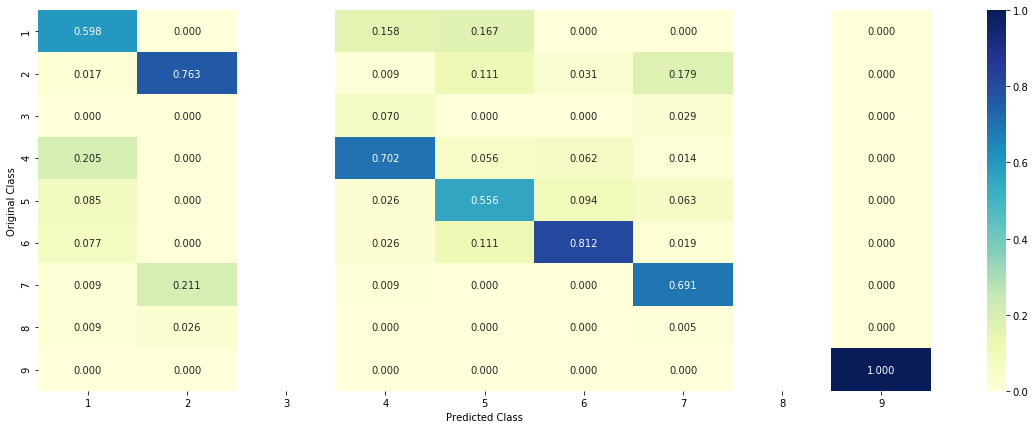

Recall matrix


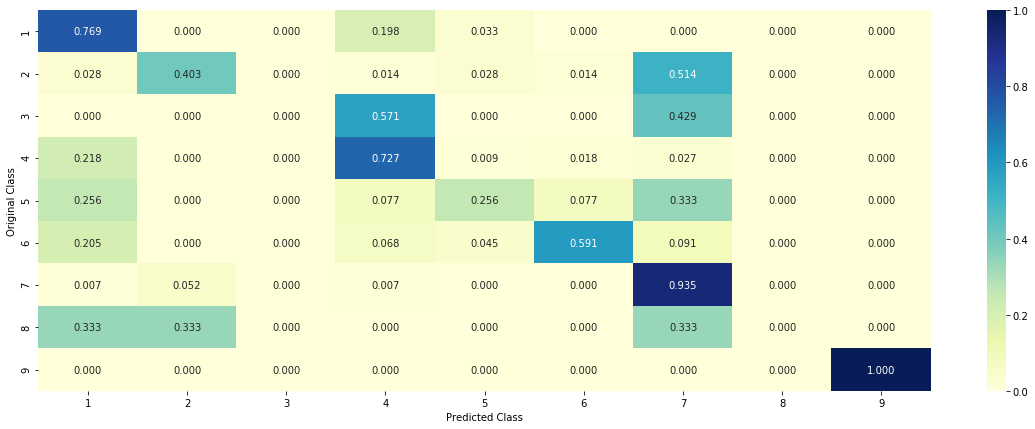

In [72]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_onehotCoding, train_y)
clf_cali = CalibratedClassifierCV(clf, method="sigmoid")
clf_cali.fit(train_onehotCoding, train_y)
clf_probs = clf_cali.predict_proba(cv_onehotCoding)
print("Log Loss :",log_loss(cv_y, clf_probs))
print("Number of missclassified point :", np.count_nonzero((clf_cali.predict(cv_onehotCoding)- cv_y))/cv_y.shape[0])
plot_confusion_matrix(cv_y, clf_cali.predict(cv_onehotCoding))

<h3>Feature Importance for a Query point</h3>

In [73]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_onehotCoding,train_y)
test_query_point = 1
num_feature = 500
predicted_class = clf_cali.predict(test_onehotCoding[test_query_point])
print("Predicted Class :", predicted_class[0])
print("Predicted Class Probabilities:", np.round(clf_cali.predict_proba(test_onehotCoding[test_query_point]),3))
print("Actual Class :", test_y[test_query_point])
indices = np.argsort(-abs(clf.coef_))[predicted_cls-1][:,:num_feature]


impfeature_names(indices[0], X_test['TEXT'].iloc[test_query_point],X_test['Gene'].iloc[test_query_point],X_test['Variation'].iloc[test_query_point], num_feature)



Predicted Class : 7
Predicted Class Probabilities: [[0.035 0.134 0.016 0.057 0.022 0.022 0.696 0.008 0.009]]
Actual Class : 7
63 Text feature [downstream] present in test data point [True]
107 Text feature [enhanced] present in test data point [True]
115 Text feature [pathways] present in test data point [True]
128 Text feature [expressing] present in test data point [True]
158 Text feature [overexpression] present in test data point [True]
186 Text feature [activated] present in test data point [True]
194 Text feature [approximately] present in test data point [True]
219 Text feature [derived] present in test data point [True]
238 Text feature [activation] present in test data point [True]
249 Text feature [showing] present in test data point [True]
256 Text feature [oncogene] present in test data point [True]
266 Text feature [3b] present in test data point [True]
268 Text feature [factor] present in test data point [True]
270 Text feature [substrate] present in test data point [True

<h3> Linear Support Vector Machines</h3>

<h3> Hyper paramter tuning</h3>

for C = 1e-05
Log Loss : 1.0533426691700734
for C = 0.0001
Log Loss : 1.019824747083005
for C = 0.001
Log Loss : 1.0423231840751754
for C = 0.01
Log Loss : 1.356745714103377
for C = 0.1
Log Loss : 1.6388184581593113
for C = 1
Log Loss : 1.789638399622569
for C = 10
Log Loss : 1.7896383142940184
for C = 100
Log Loss : 1.789638415394833


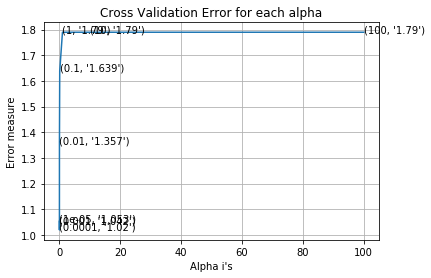

For values of best alpha =  0.0001 The train log loss is: 0.5067320426943508
For values of best alpha =  0.0001 The cross validation log loss is: 1.019824747083005
For values of best alpha =  0.0001 The test log loss is: 1.0083369228368584


In [74]:

alpha = [10 ** x for x in range(-5, 3)]
cv_error = []
for i in alpha:
    print("for C =", i)

    clf = SGDClassifier( class_weight='balanced', alpha=i, penalty='l2', loss='hinge', random_state=42)
    clf.fit(train_onehotCoding, train_y)
    clf_cali = CalibratedClassifierCV(clf, method="sigmoid")
    clf_cali.fit(train_onehotCoding, train_y)
    clf_probs = clf_cali.predict_proba(cv_onehotCoding)
    cv_error.append(log_loss(cv_y, clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha,cv_error)
for i, txt in enumerate(np.round(cv_error,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_error[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_error)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(train_onehotCoding, train_y)
clf_cali = CalibratedClassifierCV(clf, method="sigmoid")
clf_cali.fit(train_onehotCoding, train_y)

predict_y = clf_cali.predict_proba(train_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = clf_cali.predict_proba(cv_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = clf_cali.predict_proba(test_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

<h3> Testing model with best hyper parameters</h3>

Log Loss : 1.019824747083005
Number of missclassified point : 0.31390977443609025
Confusion matrix


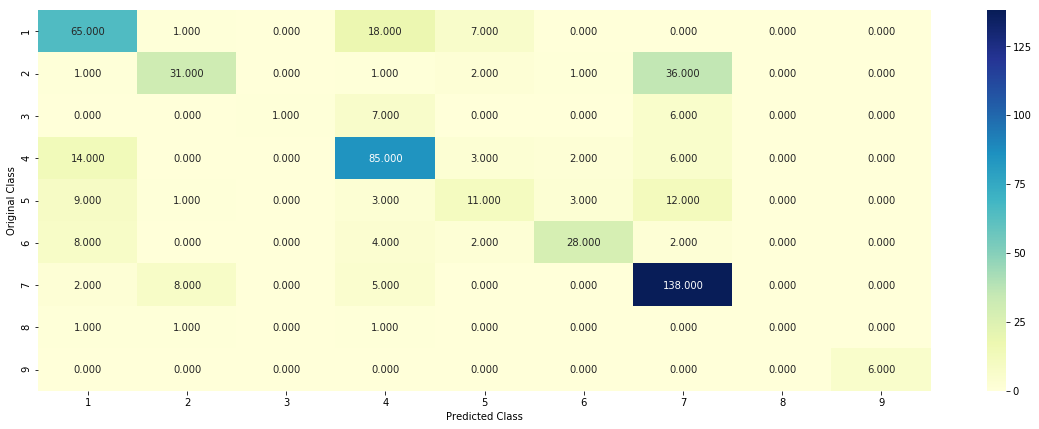

Precision matrix


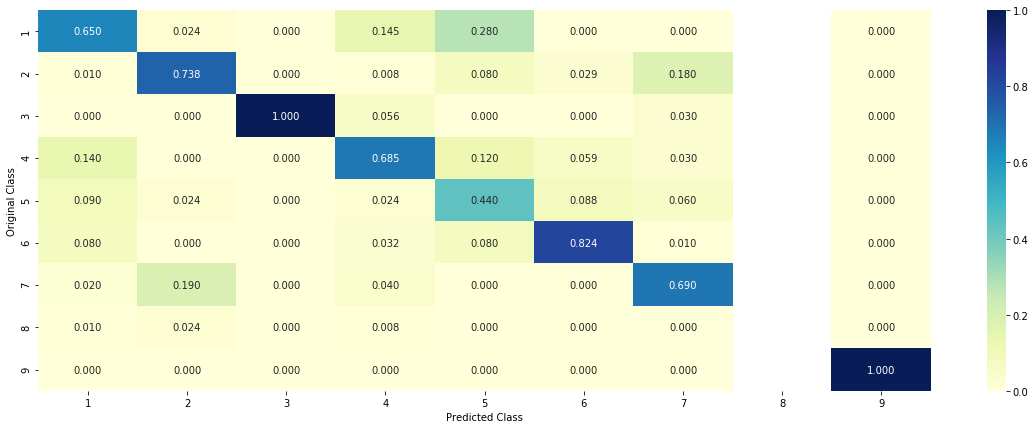

Recall matrix


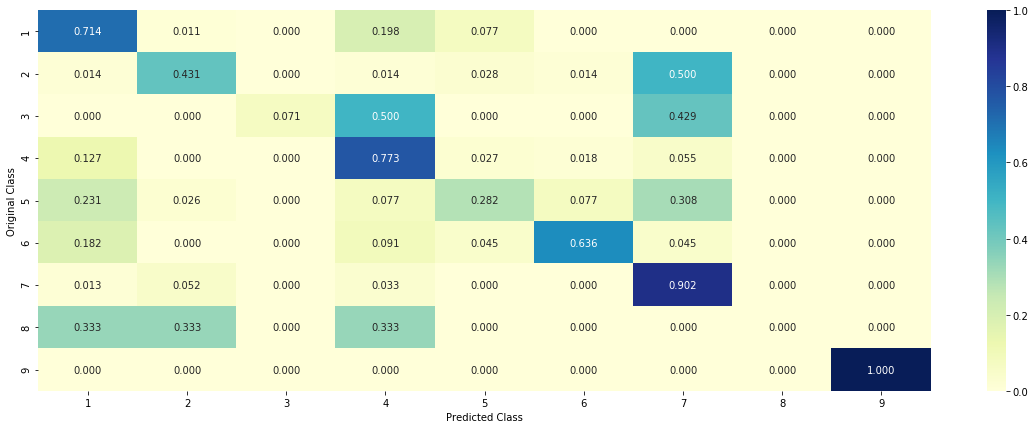

In [75]:
clf = SGDClassifier(class_weight='balanced',alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(train_onehotCoding, train_y)
clf_cali = CalibratedClassifierCV(clf, method="sigmoid")
clf_cali.fit(train_onehotCoding, train_y)
clf_probs = clf_cali.predict_proba(cv_onehotCoding)
print("Log Loss :",log_loss(cv_y, clf_probs))
print("Number of missclassified point :", np.count_nonzero((clf_cali.predict(cv_onehotCoding)- cv_y))/cv_y.shape[0])
plot_confusion_matrix(cv_y, clf_cali.predict(cv_onehotCoding))

<h3> Feature Importance for a query point</h3>

In [76]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(train_onehotCoding,train_y)
test_query_point = 1
num_feature = 500
predicted_class = clf_cali.predict(test_onehotCoding[test_query_point])
print("Predicted Class :", predicted_class[0])
print("Predicted Class Probabilities:", np.round(clf_cali.predict_proba(test_onehotCoding[test_query_point]),4))
print("Actual Class :", test_y[test_query_point])
indices = np.argsort(-abs(clf.coef_))[predicted_cls-1][:,:num_feature]


impfeature_names(indices[0], X_test['TEXT'].iloc[test_query_point],X_test['Gene'].iloc[test_query_point],X_test['Variation'].iloc[test_query_point], num_feature)




Predicted Class : 7
Predicted Class Probabilities: [[0.0988 0.1198 0.0217 0.0489 0.0278 0.0437 0.6193 0.0077 0.0123]]
Actual Class : 7
102 Text feature [derived] present in test data point [True]
104 Text feature [downstream] present in test data point [True]
108 Text feature [oncogene] present in test data point [True]
441 Text feature [enhanced] present in test data point [True]
443 Text feature [expressing] present in test data point [True]
444 Text feature [s3] present in test data point [True]
445 Text feature [pathways] present in test data point [True]
449 Text feature [38] present in test data point [True]
450 Text feature [3b] present in test data point [True]
452 Text feature [approximately] present in test data point [True]
453 Text feature [showing] present in test data point [True]
457 Text feature [substrate] present in test data point [True]
460 Text feature [pattern] present in test data point [True]
462 Text feature [response] present in test data point [True]
463 Text

<h3> Random Forest With One Hot Encoding</h3>

<h3> Hyper paramter tuning</h3>

In [77]:

alpha = [100,200,500,1000,2000]
max_depth = [5, 10]
cv_error = []
for i in alpha:
    for j in max_depth:
        print("for no_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_onehotCoding, train_y)
        clf_cali = CalibratedClassifierCV(clf, method="sigmoid")
        clf_cali.fit(train_onehotCoding, train_y)
        clf_probs = clf_cali.predict_proba(cv_onehotCoding)
        cv_error.append(log_loss(cv_y, clf_probs, labels=clf.classes_, eps=1e-15))
        print("Log Loss :",log_loss(cv_y, clf_probs)) 


best_alpha = np.argmin(cv_error)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
clf.fit(train_onehotCoding, train_y)
clf_cali = CalibratedClassifierCV(clf, method="sigmoid")
clf_cali.fit(train_onehotCoding, train_y)

predict_y = clf_cali.predict_proba(train_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = clf_cali.predict_proba(cv_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = clf_cali.predict_proba(test_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))




for no_estimators = 100 and max depth =  5
Log Loss : 1.2408672623953243
for no_estimators = 100 and max depth =  10
Log Loss : 1.2324098384605622
for no_estimators = 200 and max depth =  5
Log Loss : 1.2160313440146195
for no_estimators = 200 and max depth =  10
Log Loss : 1.2159402333391733
for no_estimators = 500 and max depth =  5
Log Loss : 1.1982981319211272
for no_estimators = 500 and max depth =  10
Log Loss : 1.2125234286628377
for no_estimators = 1000 and max depth =  5
Log Loss : 1.1979345536168953
for no_estimators = 1000 and max depth =  10
Log Loss : 1.2090337965287263
for no_estimators = 2000 and max depth =  5
Log Loss : 1.1961077401968865
for no_estimators = 2000 and max depth =  10
Log Loss : 1.2049827661857764
For values of best estimator =  2000 The train log loss is: 0.8735095231606014
For values of best estimator =  2000 The cross validation log loss is: 1.1961077401968865
For values of best estimator =  2000 The test log loss is: 1.1660587496710955


<h3>Testing model with best hyper parameters</h3>

Log Loss : 1.1961077401968863
Number of missclassified point : 0.40977443609022557
Confusion matrix


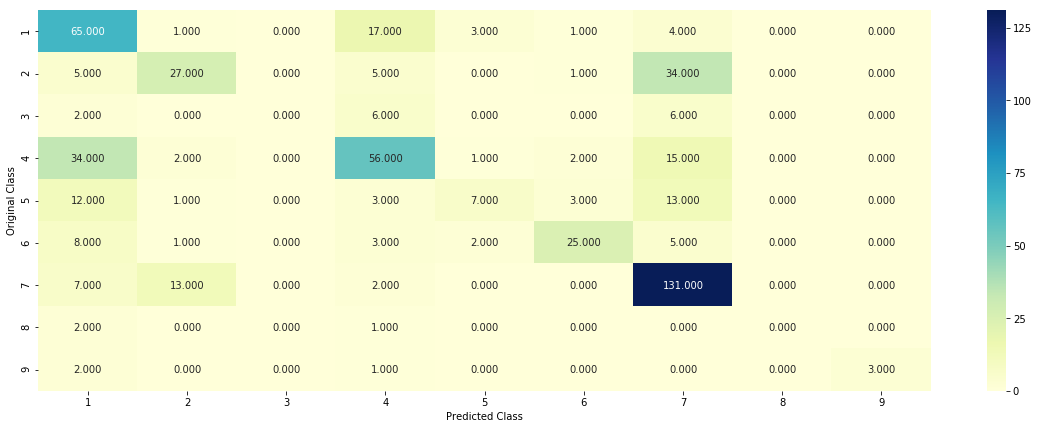

Precision matrix


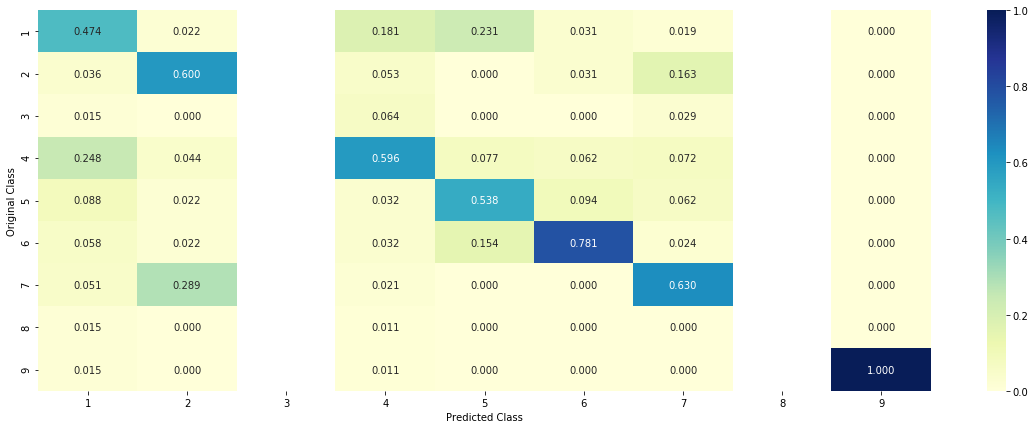

Recall matrix


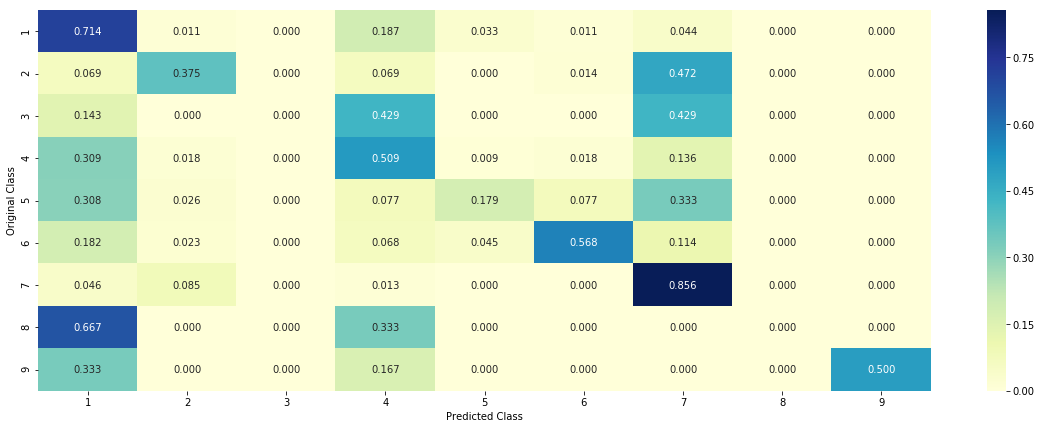

In [78]:

clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
clf.fit(train_onehotCoding, train_y)
clf_cali = CalibratedClassifierCV(clf, method="sigmoid")
clf_cali.fit(train_onehotCoding, train_y)
clf_probs = clf_cali.predict_proba(cv_onehotCoding)
print("Log Loss :",log_loss(cv_y, clf_probs))
print("Number of missclassified point :", np.count_nonzero((clf_cali.predict(cv_onehotCoding)- cv_y))/cv_y.shape[0])
plot_confusion_matrix(cv_y, clf_cali.predict(cv_onehotCoding))




<h3> Feature Importance for a Query Point</h3>

In [79]:
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
clf.fit(train_onehotCoding, train_y)
clf_cali = CalibratedClassifierCV(clf, method="sigmoid")
clf_cali.fit(train_onehotCoding, train_y)

test_query_point = 1
num_feature = 100
predicted_class = clf_cali.predict(test_onehotCoding[test_query_point])
print("Predicted Class :", predicted_class[0])
print("Predicted Class Probabilities:", np.round(clf_cali.predict_proba(test_onehotCoding[test_query_point]),4))
print("Actual Class :", test_y[test_query_point])
indices = np.argsort(-clf.feature_importances_)


impfeature_names(indices[:num_feature], X_test['TEXT'].iloc[test_query_point],X_test['Gene'].iloc[test_query_point],X_test['Variation'].iloc[test_query_point], num_feature)






Predicted Class : 7
Predicted Class Probabilities: [[0.1274 0.1517 0.0201 0.1765 0.0555 0.0521 0.3966 0.0093 0.0107]]
Actual Class : 7
1 Text feature [activating] present in test data point [True]
4 Text feature [inhibitors] present in test data point [True]
6 Text feature [suppressor] present in test data point [True]
8 Text feature [activation] present in test data point [True]
9 Text feature [function] present in test data point [True]
10 Text feature [activated] present in test data point [True]
12 Text feature [treatment] present in test data point [True]
13 Text feature [phosphorylation] present in test data point [True]
14 Text feature [inhibitor] present in test data point [True]
15 Text feature [loss] present in test data point [True]
16 Text feature [missense] present in test data point [True]
18 Text feature [constitutive] present in test data point [True]
19 Text feature [oncogenic] present in test data point [True]
21 Text feature [cells] present in test data point [True]


<h3>Random Forest with Response Coding</h3>

In [80]:

alpha = [10,50,100,200,500,1000]
max_depth = [2,3,5,10]
cv_error= []
for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_responseCoding, train_y)
        clf_cali = CalibratedClassifierCV(clf, method="sigmoid")
        clf_cali.fit(train_responseCoding, train_y)
        clf_probs = clf_cali.predict_proba(cv_responseCoding)
        cv_error.append(log_loss(cv_y, clf_probs, labels=clf.classes_, eps=1e-15))
        print("Log Loss :",log_loss(cv_y, clf_probs)) 

best_alpha = np.argmin(cv_error)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/4)], criterion='gini', max_depth=max_depth[int(best_alpha%4)], random_state=42, n_jobs=-1)
clf.fit(train_responseCoding, train_y)
clf_cali = CalibratedClassifierCV(clf, method="sigmoid")
clf_cali.fit(train_responseCoding, train_y)

predict_y = clf_cali.predict_proba(train_responseCoding)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = clf_cali.predict_proba(cv_responseCoding)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = clf_cali.predict_proba(test_responseCoding)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

for n_estimators = 10 and max depth =  2
Log Loss : 1.9266257118855339
for n_estimators = 10 and max depth =  3
Log Loss : 1.5231988951298678
for n_estimators = 10 and max depth =  5
Log Loss : 1.4120565265159313
for n_estimators = 10 and max depth =  10
Log Loss : 1.7163073427783366
for n_estimators = 50 and max depth =  2
Log Loss : 1.5811376117827982
for n_estimators = 50 and max depth =  3
Log Loss : 1.3075131469836747
for n_estimators = 50 and max depth =  5
Log Loss : 1.3499742838141793
for n_estimators = 50 and max depth =  10
Log Loss : 1.4787591092172605
for n_estimators = 100 and max depth =  2
Log Loss : 1.456316329747039
for n_estimators = 100 and max depth =  3
Log Loss : 1.3122640858559005
for n_estimators = 100 and max depth =  5
Log Loss : 1.28907541468594
for n_estimators = 100 and max depth =  10
Log Loss : 1.4529478203183193
for n_estimators = 200 and max depth =  2
Log Loss : 1.4597404137560595
for n_estimators = 200 and max depth =  3
Log Loss : 1.3344661423514506


<h3> Testing model with best hyper parameters</h3>

Log Loss : 1.2408672623953243
Number of missclassified point : 0.42857142857142855
Confusion matrix


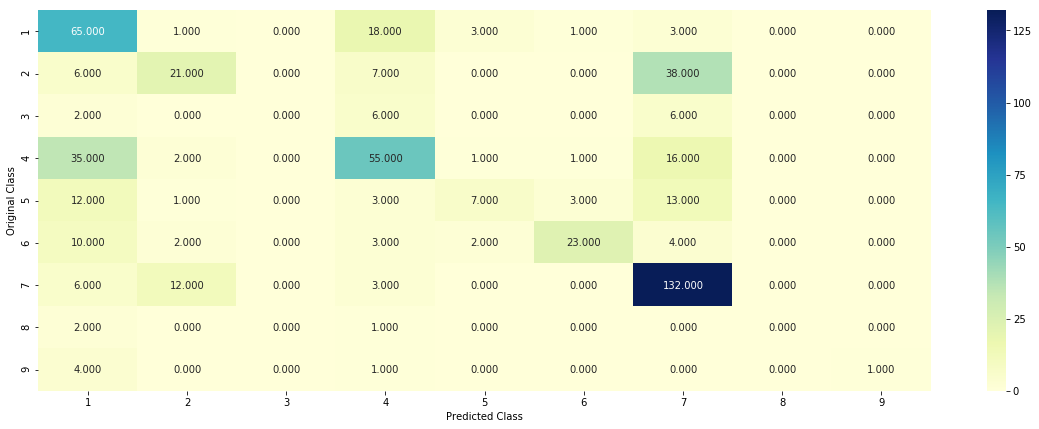

Precision matrix


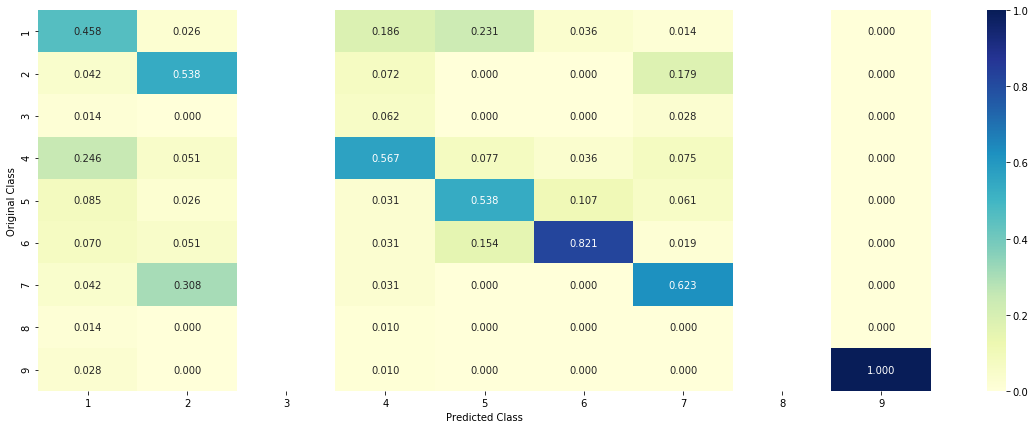

Recall matrix


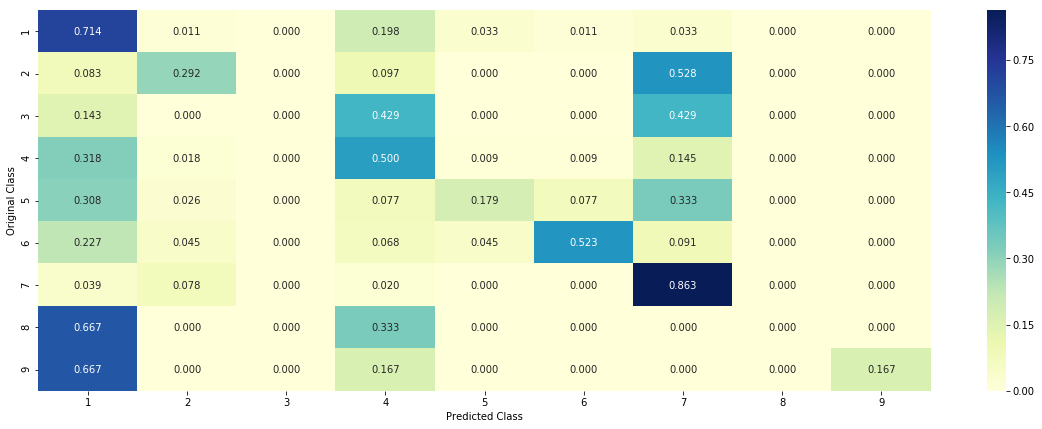

In [81]:
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/4)], criterion='gini', max_depth=max_depth[int(best_alpha%4)], random_state=42, n_jobs=-1)
clf.fit(train_onehotCoding, train_y)
clf_cali = CalibratedClassifierCV(clf, method="sigmoid")
clf_cali.fit(train_onehotCoding, train_y)
clf_probs = clf_cali.predict_proba(cv_onehotCoding)
print("Log Loss :",log_loss(cv_y, clf_probs))
print("Number of missclassified point :", np.count_nonzero((clf_cali.predict(cv_onehotCoding)- cv_y))/cv_y.shape[0])
plot_confusion_matrix(cv_y, clf_cali.predict(cv_onehotCoding))




<h3> Feature Importance</h3>

In [82]:
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/4)], criterion='gini', max_depth=max_depth[int(best_alpha%4)], random_state=42, n_jobs=-1)
clf.fit(train_responseCoding, train_y)
clf_cali = CalibratedClassifierCV(clf, method="sigmoid")
clf_cali.fit(train_responseCoding, train_y)


test_query_point = 2
no_feature = 27
predicted_class = clf_cali.predict(test_responseCoding[test_query_point].reshape(1,-1))
print("Predicted Class :", predicted_class[0])
print("Predicted Class Probabilities:", np.round(clf_cali.predict_proba(test_responseCoding[test_query_point].reshape(1,-1)),4))
print("Actual Class :", test_y[test_query_point])
k = np.argsort(-clf.feature_importances_)
print("-"*50)
for i in k:
    if i<9:
        print("Gene is important feature")
    elif i<18:
        print("Variation is important feature")
    else:
        print("Text is important feature")

Predicted Class : 8
Predicted Class Probabilities: [[0.2054 0.1974 0.0764 0.0532 0.0156 0.0514 0.0323 0.2637 0.1045]]
Actual Class : 1
--------------------------------------------------
Variation is important feature
Variation is important feature
Variation is important feature
Variation is important feature
Gene is important feature
Variation is important feature
Variation is important feature
Text is important feature
Text is important feature
Gene is important feature
Text is important feature
Text is important feature
Text is important feature
Gene is important feature
Gene is important feature
Variation is important feature
Text is important feature
Gene is important feature
Text is important feature
Gene is important feature
Variation is important feature
Text is important feature
Text is important feature
Variation is important feature
Gene is important feature
Gene is important feature
Gene is important feature


<h3>Stacking</h3>

<h3> Hyper parameter tuning</h3>

In [83]:


clf1 = SGDClassifier(alpha=0.0001, penalty='l2', loss='log', class_weight='balanced', random_state=0)
clf1.fit(train_onehotCoding, train_y)
clf1_cali = CalibratedClassifierCV(clf1, method="sigmoid")

clf2 = SGDClassifier(alpha=0.0001, penalty='l2', loss='hinge', class_weight='balanced', random_state=0)
clf2.fit(train_onehotCoding, train_y)
clf2_cali = CalibratedClassifierCV(clf2, method="sigmoid")


clf3 = MultinomialNB(alpha=0.01)
clf3.fit(train_onehotCoding, train_y)
clf3_cali = CalibratedClassifierCV(clf3, method="sigmoid")

clf1_cali.fit(train_onehotCoding, train_y)
print("Logistic Regression :  Log Loss: %0.2f" % (log_loss(cv_y, clf1_cali.predict_proba(cv_onehotCoding))))
clf2_cali.fit(train_onehotCoding, train_y)
print("Support vector machines : Log Loss: %0.2f" % (log_loss(cv_y, clf2_cali.predict_proba(cv_onehotCoding))))
clf3_cali.fit(train_onehotCoding, train_y)
print("Naive Bayes : Log Loss: %0.2f" % (log_loss(cv_y, clf3_cali.predict_proba(cv_onehotCoding))))

alpha = [0.0001,0.001,0.01,0.1,1,10] 
for i in alpha:
    lr = LogisticRegression(C=i)
    stack = StackingClassifier(classifiers=[clf1_cali, clf2_cali, clf3_cali], meta_classifier=lr, use_probas=True)
    stack.fit(train_onehotCoding, train_y)
    print("Stacking Classifer : for the value of alpha: %f Log Loss: %0.3f" % (i, log_loss(cv_y, stack.predict_proba(cv_onehotCoding))))
    
    

Logistic Regression :  Log Loss: 0.96
Support vector machines : Log Loss: 1.00
Naive Bayes : Log Loss: 1.17
Stacking Classifer : for the value of alpha: 0.000100 Log Loss: 2.172
Stacking Classifer : for the value of alpha: 0.001000 Log Loss: 1.980
Stacking Classifer : for the value of alpha: 0.010000 Log Loss: 1.353
Stacking Classifer : for the value of alpha: 0.100000 Log Loss: 1.054
Stacking Classifer : for the value of alpha: 1.000000 Log Loss: 1.259
Stacking Classifer : for the value of alpha: 10.000000 Log Loss: 1.677


<h3>Testing the model with the best hyper parameters</h3>

Log loss (train) on the stacking classifier : 0.3537248924360145
Log loss (CV) on the stacking classifier : 1.05394088464119
Log loss (test) on the stacking classifier : 1.0743244575113722
Number of missclassified point : 0.34887218045112783
Confusion matrix


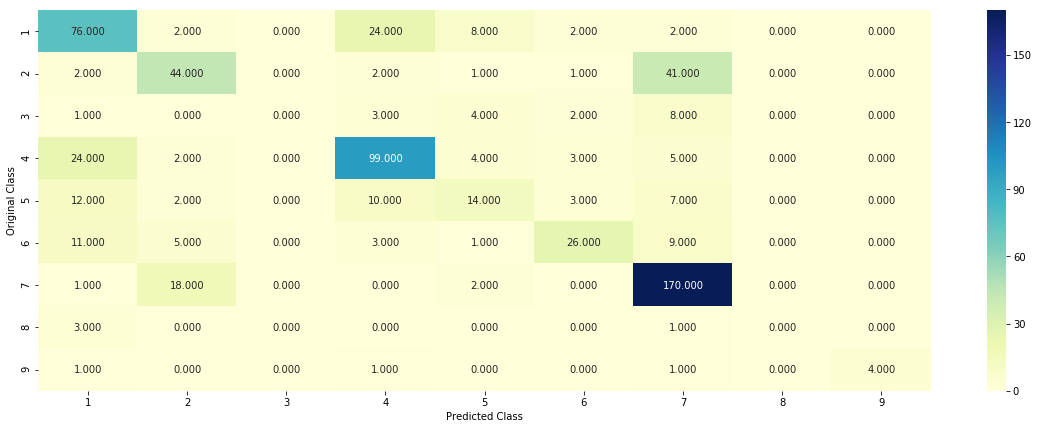

Precision matrix


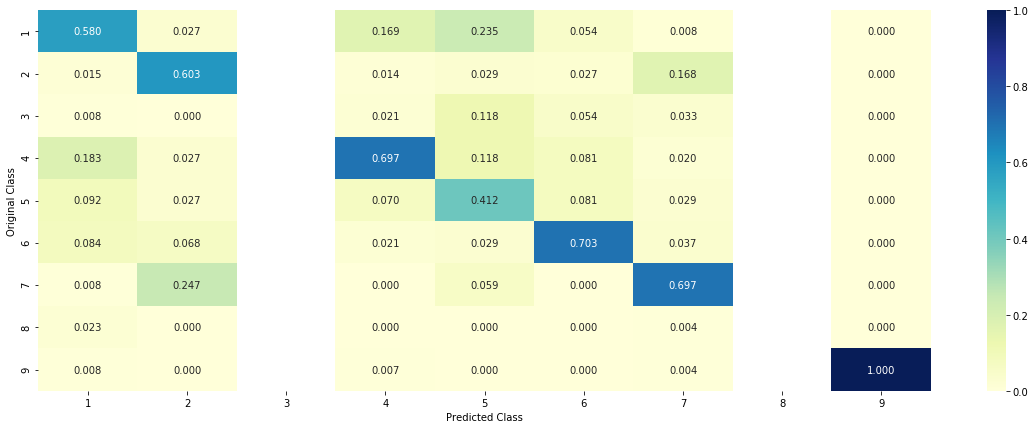

Recall matrix


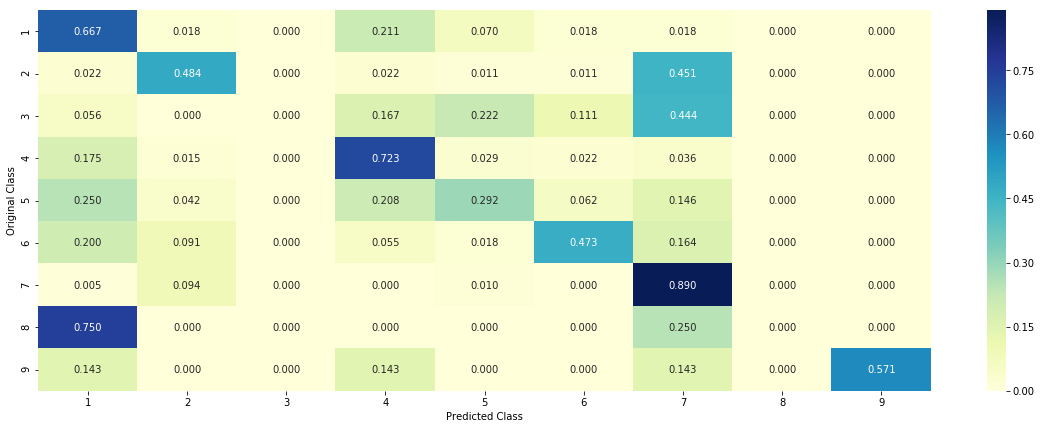

In [86]:
lr = LogisticRegression(C=0.1)
stack = StackingClassifier(classifiers=[clf1_cali, clf2_cali, clf3_cali], meta_classifier=lr, use_probas=True)
stack.fit(train_onehotCoding, train_y)

log_error = log_loss(train_y, stack.predict_proba(train_onehotCoding))
print("Log loss (train) on the stacking classifier :",log_error)

log_error = log_loss(cv_y, stack.predict_proba(cv_onehotCoding))
print("Log loss (CV) on the stacking classifier :",log_error)

log_error = log_loss(test_y, stack.predict_proba(test_onehotCoding))
print("Log loss (test) on the stacking classifier :",log_error)

print("Number of missclassified point :", np.count_nonzero((stack.predict(test_onehotCoding)- test_y))/test_y.shape[0])
plot_confusion_matrix(test_y=test_y, predict_y=stack.predict(test_onehotCoding))






<h3> Voting classifier </h3>

Log loss (train) on the VotingClassifier : 0.49275667927040123
Log loss (CV) on the VotingClassifier : 0.9880692985776589
Log loss (test) on the VotingClassifier : 0.9952790132370265
Number of missclassified point : 0.3458646616541353
Confusion matrix


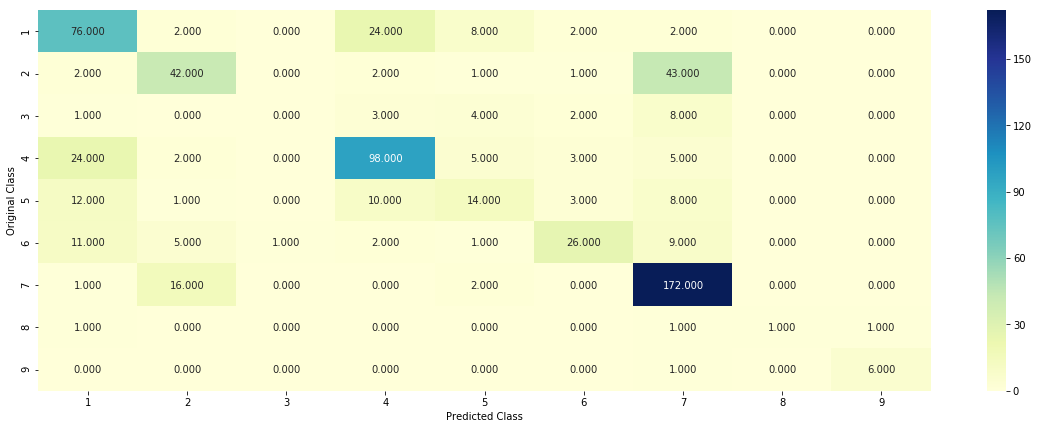

Precision matrix


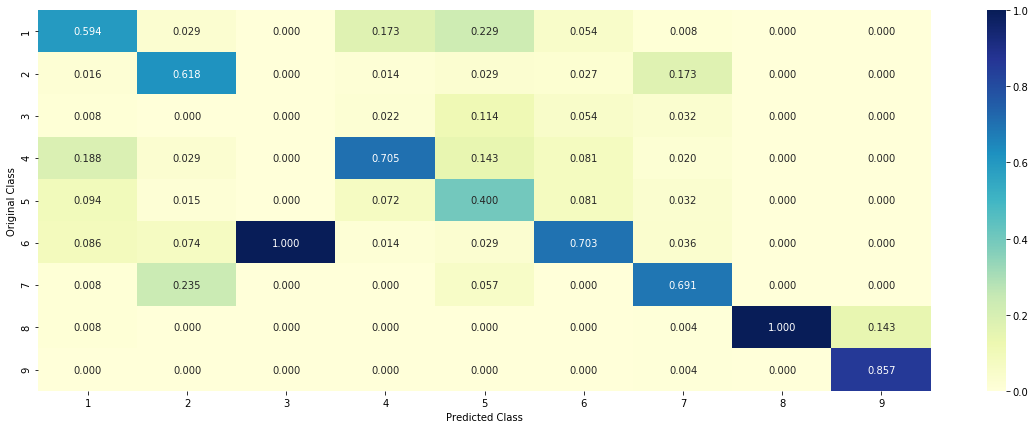

Recall matrix


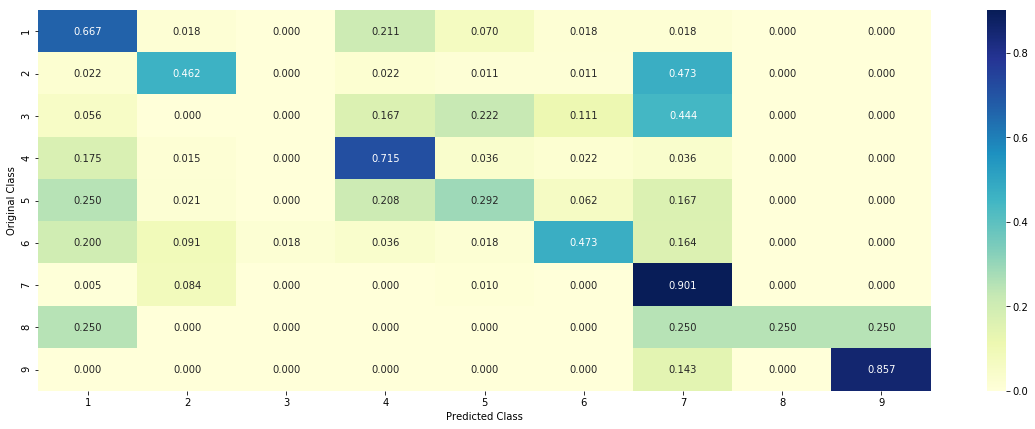

In [87]:

from sklearn.ensemble import VotingClassifier
votingclf = VotingClassifier(estimators=[('lr', clf1_cali), ('svc', clf2_cali), ('rf', clf3_cali)], voting='soft')
votingclf.fit(train_onehotCoding, train_y)
print("Log loss (train) on the VotingClassifier :", log_loss(train_y, votingclf.predict_proba(train_onehotCoding)))
print("Log loss (CV) on the VotingClassifier :", log_loss(cv_y, votingclf.predict_proba(cv_onehotCoding)))
print("Log loss (test) on the VotingClassifier :", log_loss(test_y, votingclf.predict_proba(test_onehotCoding)))
print("Number of missclassified point :", np.count_nonzero((votingclf.predict(test_onehotCoding)- test_y))/test_y.shape[0])
plot_confusion_matrix(test_y=test_y, predict_y=votingclf.predict(test_onehotCoding))





